# Statistical Research

### 1) Download libraries and modules

In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features
from scipy.stats import spearmanr, kendalltau
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pathlib import Path
from typing import Dict, Tuple, List, Optional
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [2]:
def project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for candidate in [p, *p.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    return p

### 2) Download train data

We first make data usable by downloading it into a Polars dataframe:

In [45]:
# Get the paths (for interchange between Windows and MacOS)

root_path = project_root()

# Dowload train data related files
train_data_1 = pd.read_csv(root_path / "data" / "train.csv")
train_data_2 = pd.read_csv(root_path / "data" / "train_new.csv") # in windows, use "\"

# Merge both csvs of train data
merged_data = pd.concat([train_data_1, train_data_2], axis=1)
columns = [col for col in merged_data.columns if col not in ['Y1', 'Y2']] + ['Y1', 'Y2']
merged_data = merged_data[columns]
train_data = pl.DataFrame(merged_data).with_columns(pl.col("time").cast(int)).fill_null(-1)
merged_data = merged_data.set_index("time")
merged_data.to_csv(root_path / "data" / "full_train_data.csv")
print("TRAIN DATA\n")
print(train_data)

# Take a look at what the test data looks like
print("\nTEST DATA\n")
test_data = pl.read_csv(root_path / "data" / "test.csv")
print(test_data)

TRAIN DATA

shape: (80_000, 19)
┌───────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ time  ┆ A         ┆ B         ┆ C         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ i64   ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0     ┆ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.935902 ┆ -0.310081 │
│ 1     ┆ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.089707 ┆ -0.305374 │
│ 2     ┆ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.077855 ┆ -0.631485 │
│ 3     ┆ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ … ┆ -1.0 ┆ 0.0  ┆ 0.941271  ┆ -0.535212 │
│ 4     ┆ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.039582 ┆ -0.490561 │
│ …     ┆ …         ┆ …         ┆ …         ┆ … ┆ …    ┆ …    ┆ …         ┆ …         │


Given the values of both variables, we will now take a look at how they behave. They seem to behave like returns (Y1) and volatility (Y2). And hence, we can use this information for modelling.

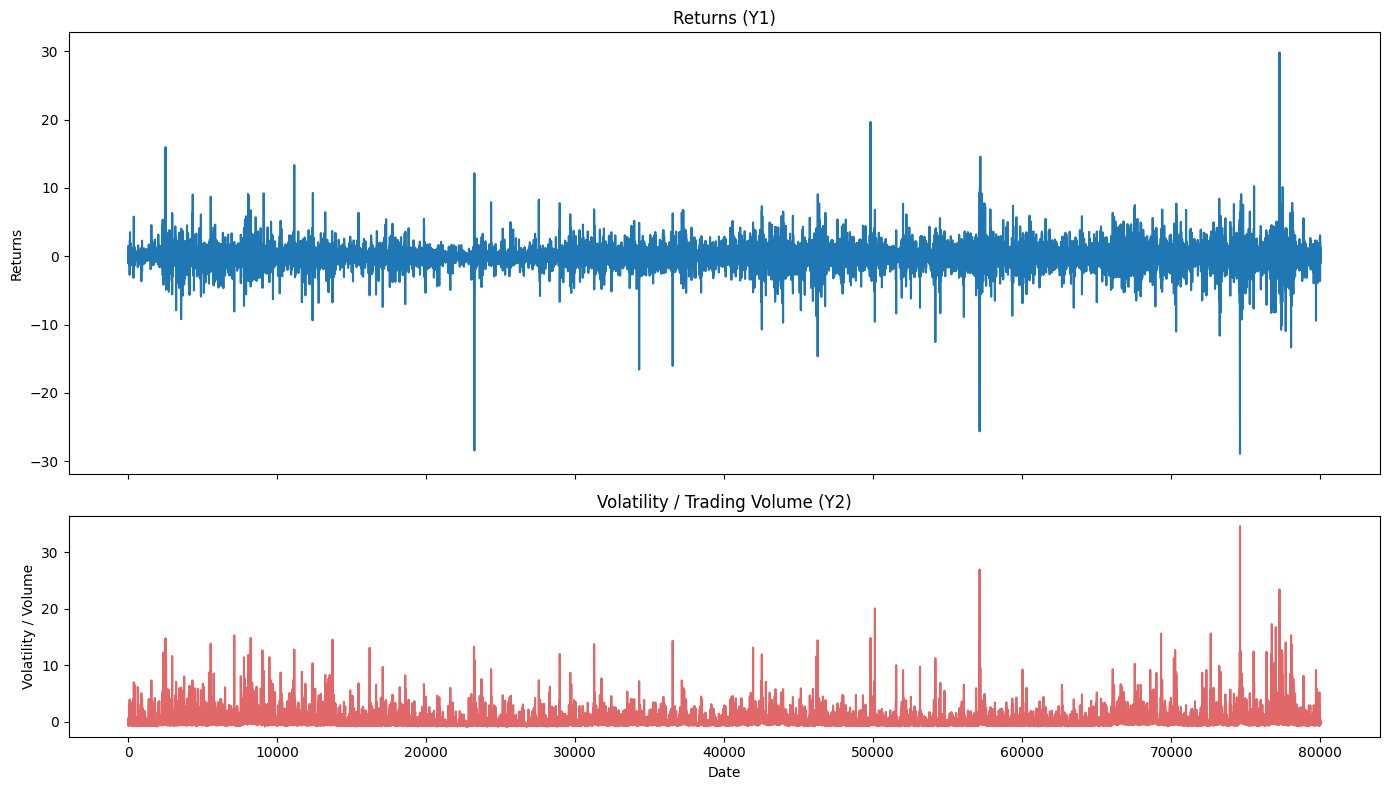

In [4]:
pdf = train_data.select(["time","Y1","Y2"]).to_pandas()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[2,1]})

# Rendimientos arriba
ax1.plot(pdf["time"], pdf["Y1"], color="tab:blue")
ax1.set_ylabel("Returns")
ax1.set_title("Returns (Y1)")

# Volatilidad/volumen abajo
ax2.plot(pdf["time"], pdf["Y2"], color="tab:red", alpha=0.7)
ax2.set_ylabel("Volatility / Volume")
ax2.set_xlabel("Date")
ax2.set_title("Volatility / Trading Volume (Y2)")

plt.tight_layout()
plt.show()


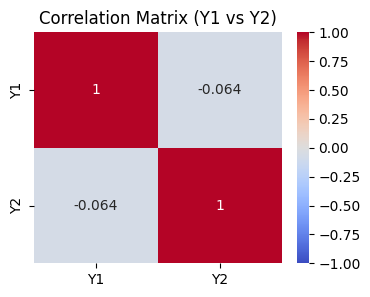

In [5]:
corr_matrix = pdf[["Y1", "Y2"]].corr(method="pearson")

plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix (Y1 vs Y2)")
plt.show()

### 3) Visualize Relationship between Targets and Explanatory Variables

Plot the features dependency with the variables into scatter plot grids:

In [6]:
def plot_grid_vs_target(target: np.ndarray, label: str, num_rows: int, num_cols: int, columns_to_plot: List[str], colour: str):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()
    corr_dict = {}
    y = np.asarray(target, dtype=float)

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col], dtype=float)

        m = np.isfinite(x) & np.isfinite(y)
        corr = np.corrcoef(x[m], y[m])[0, 1] if m.any() else np.nan

        corr_dict[col] = corr

        ax.scatter(x[m], y[m], alpha=0.5, color=colour)
        ax.set_title(f"{col} vs {label}\ncorr={corr:.4f}" if np.isfinite(corr) else f"{col} vs {label}\ncorr=nan")
        ax.set_xlabel(col)
        ax.set_ylabel(label)

    # remove unused axes (if grid > number of features)
    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Features vs {label}", y=0.995, fontsize=16)
    fig.tight_layout()
    plt.show()
    return corr_dict

def superpose_grids(targets: List[np.ndarray], labels: List[str], num_rows: int, num_cols: int, columns_to_plot: List[str], colours: List[str]):

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col].to_numpy(), dtype=float).ravel()
        corrs = [] 

        for num, target in enumerate(targets):
            y = np.asarray(target, dtype=float).ravel()
            m = np.isfinite(x) & np.isfinite(y)
            if m.sum() >= 2 and np.std(x[m]) > 0 and np.std(y[m]) > 0:
                c = np.corrcoef(x[m], y[m])[0, 1]
            else:
                c = np.nan

            corrs.append(c)
            ax.scatter(x[m], y[m], alpha=0.5, label=labels[num], color=colours[num])

        corr_txt = "  |  ".join(
            f"corr({lbl})={c:.4f}" if np.isfinite(c) else f"corr({lbl})=nan"
            for lbl, c in zip(labels, corrs)
        )
        ax.set_title(f"{col} vs targets\n{corr_txt}")
        ax.set_xlabel(col)
        ax.set_ylabel("target")
        ax.legend(loc="best")

    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

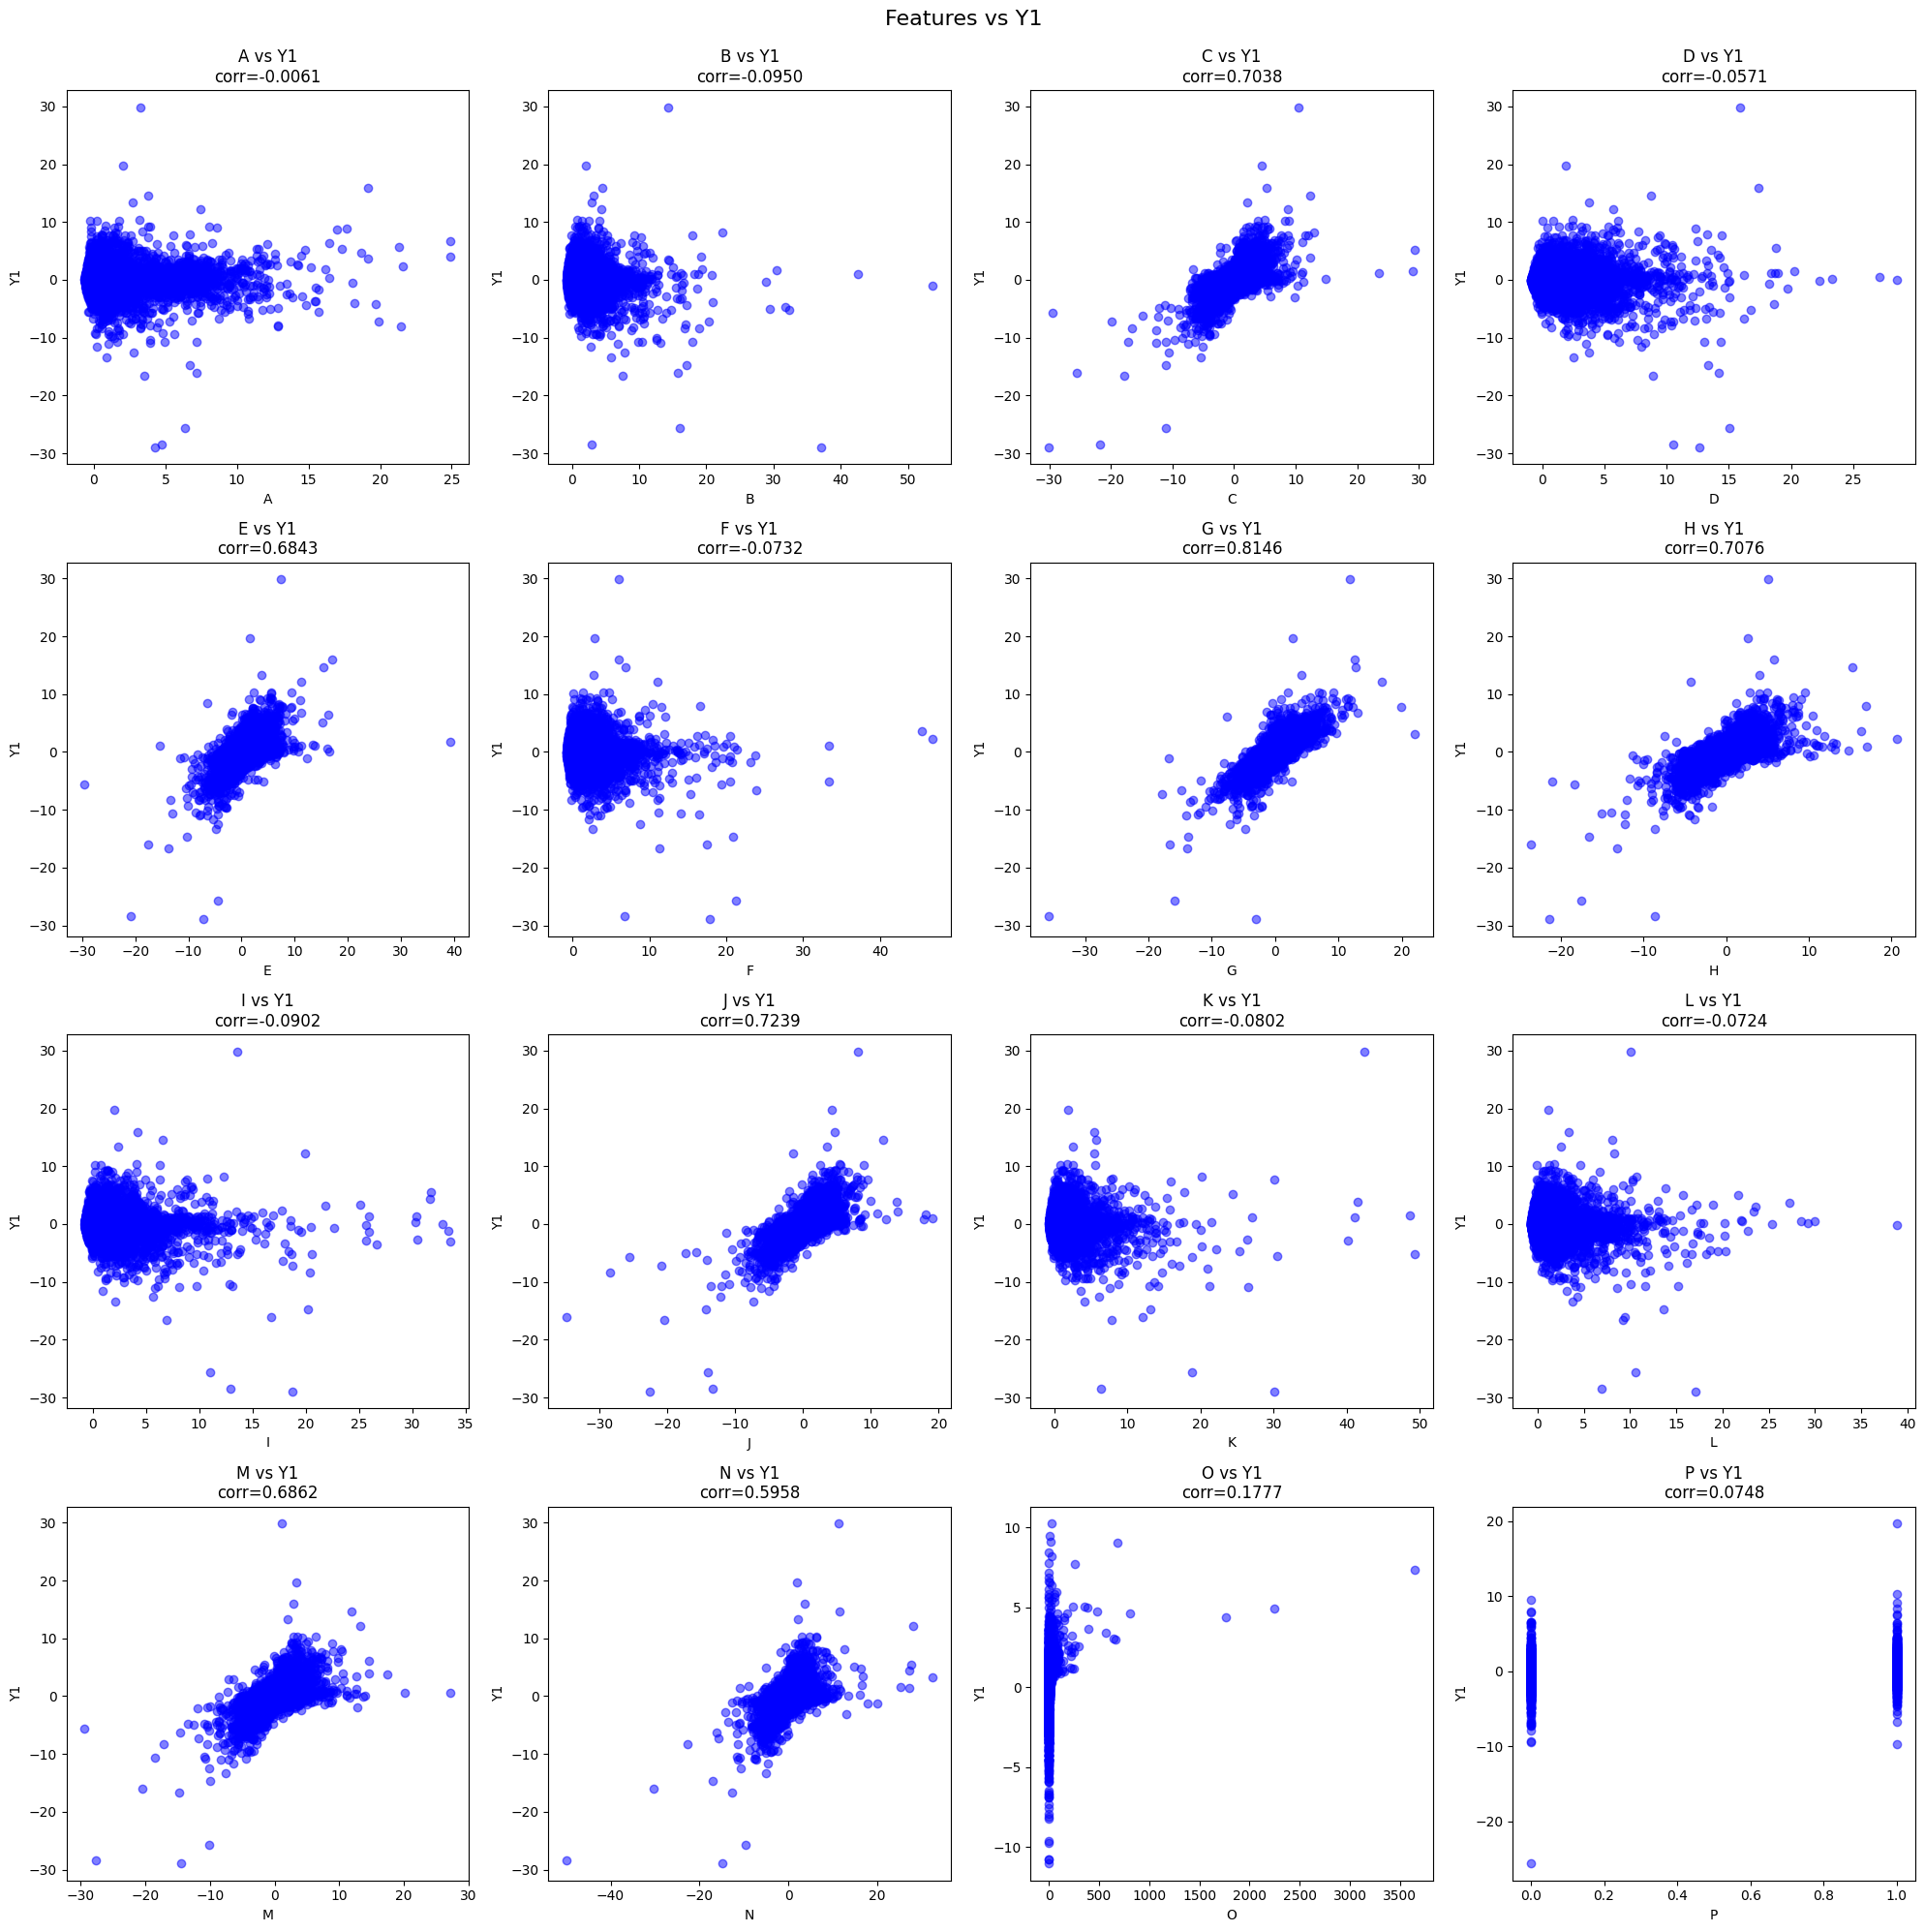

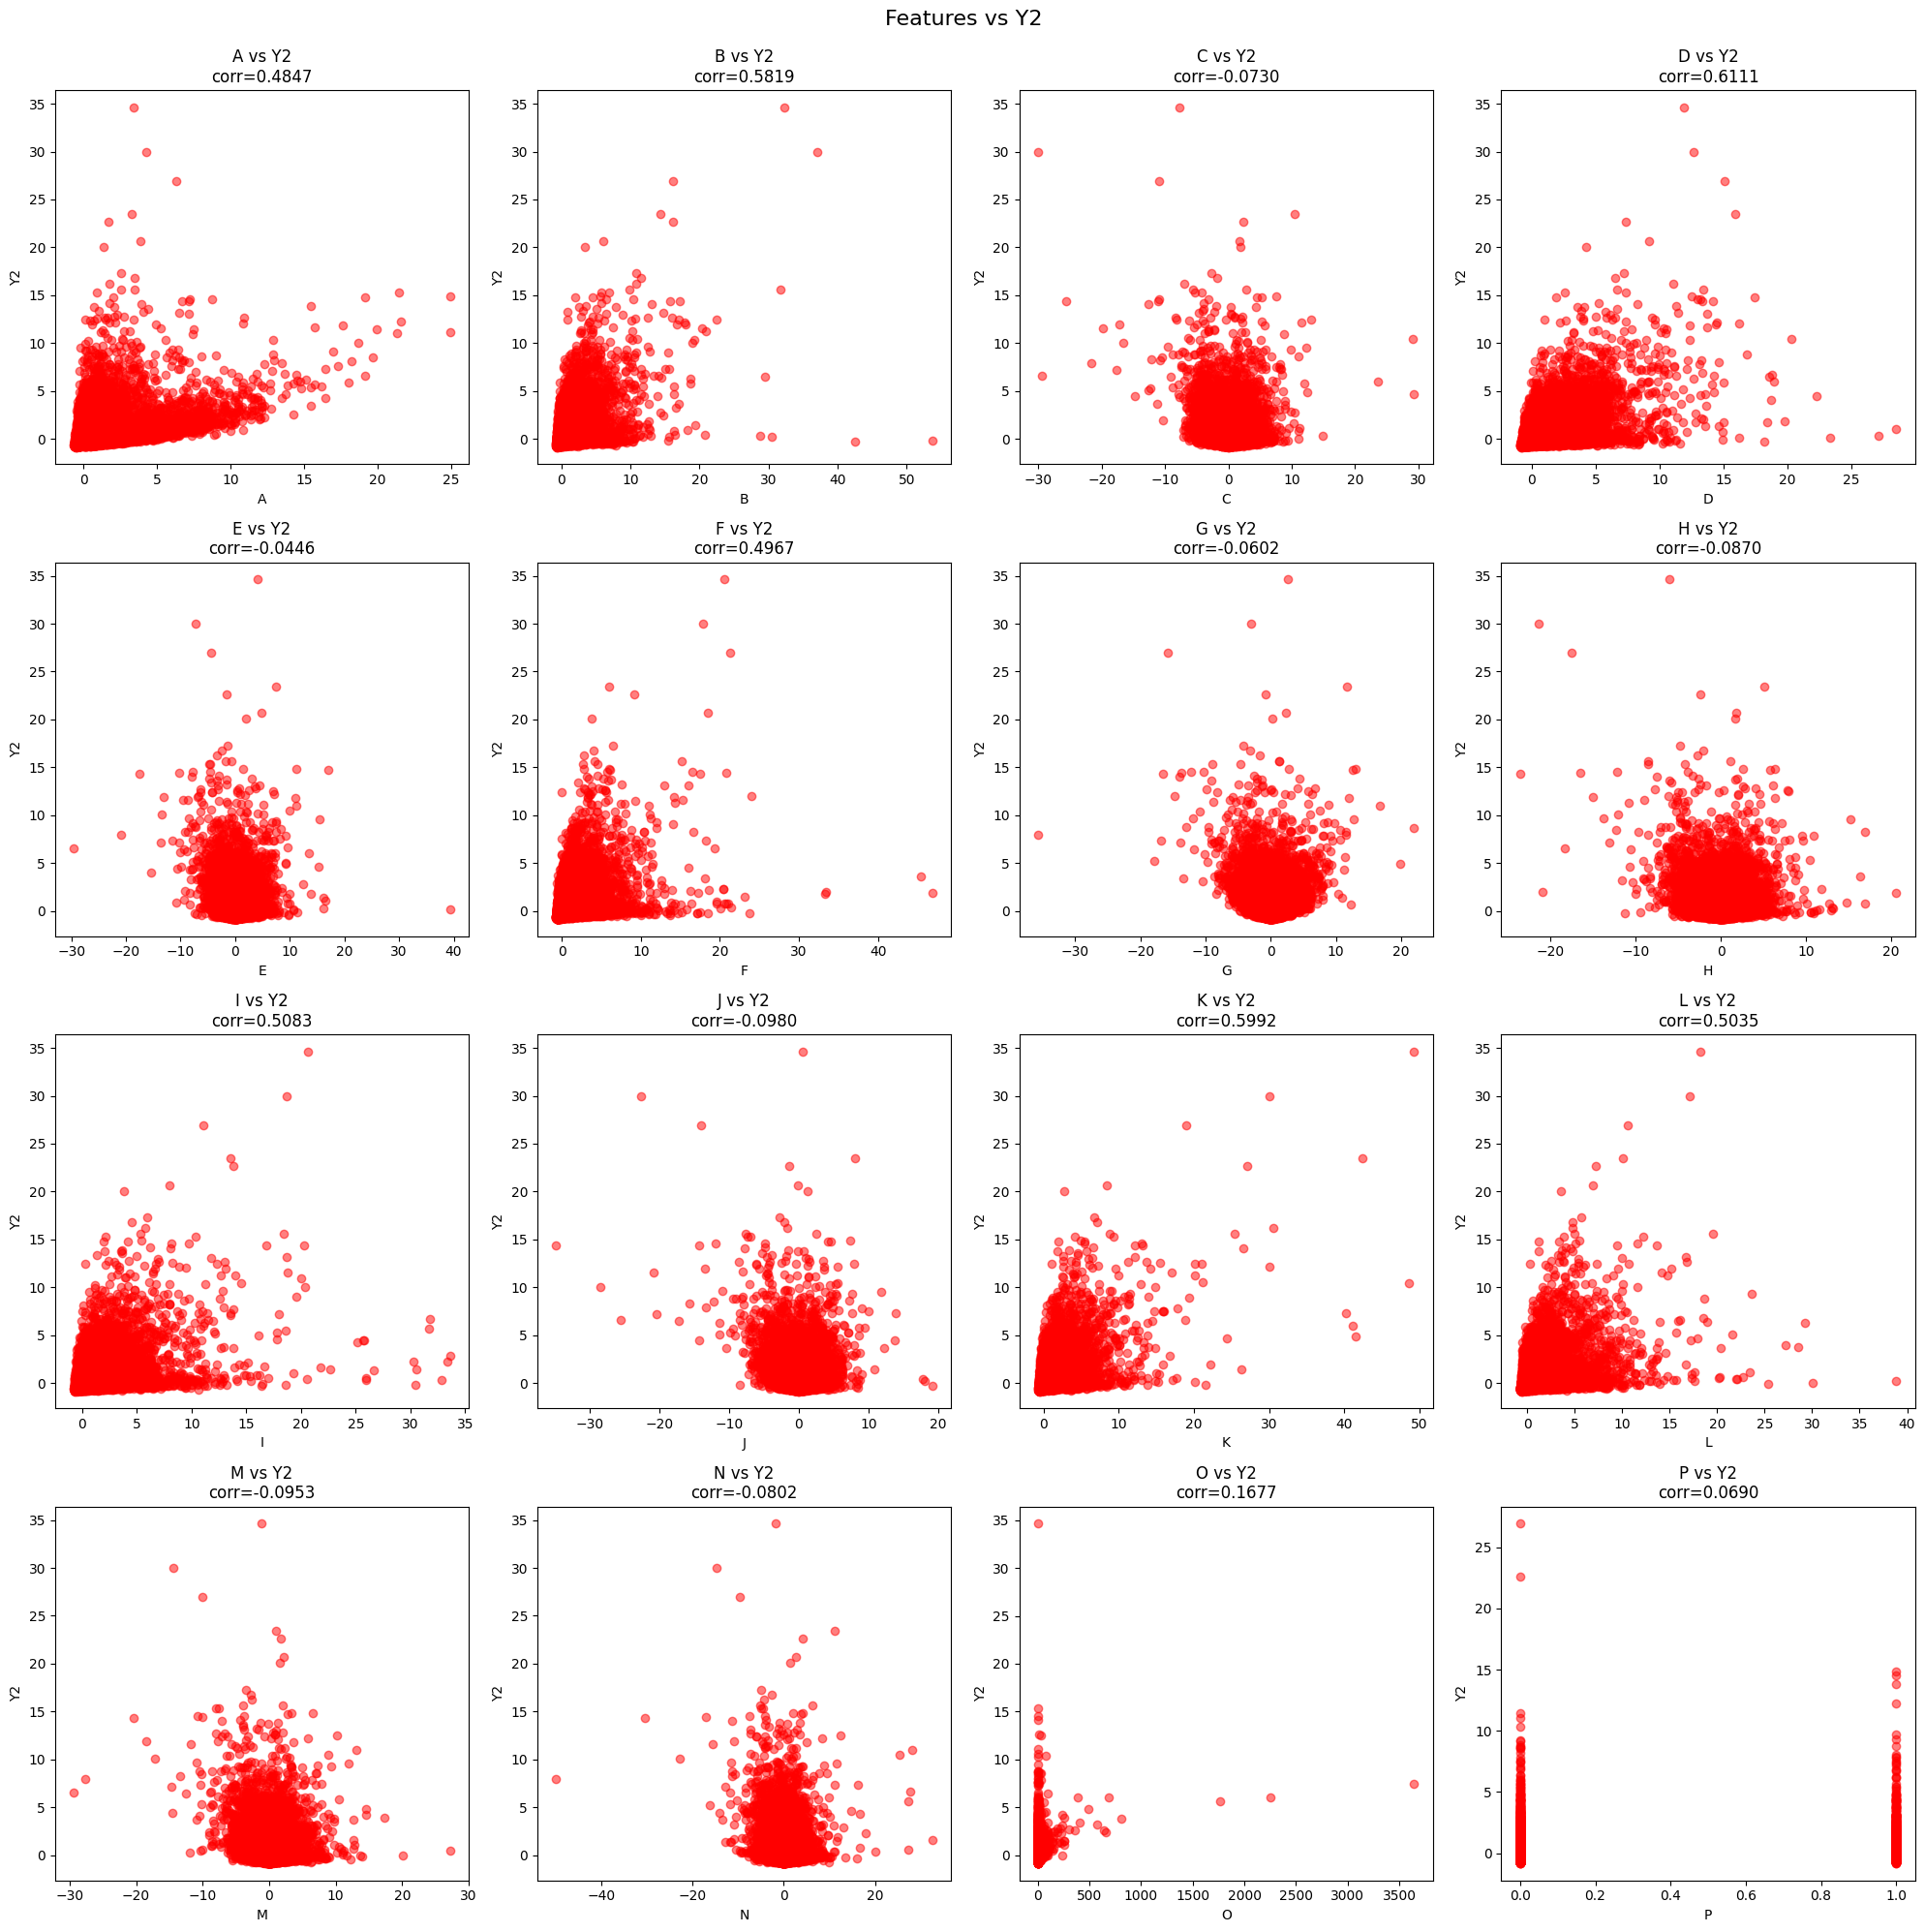

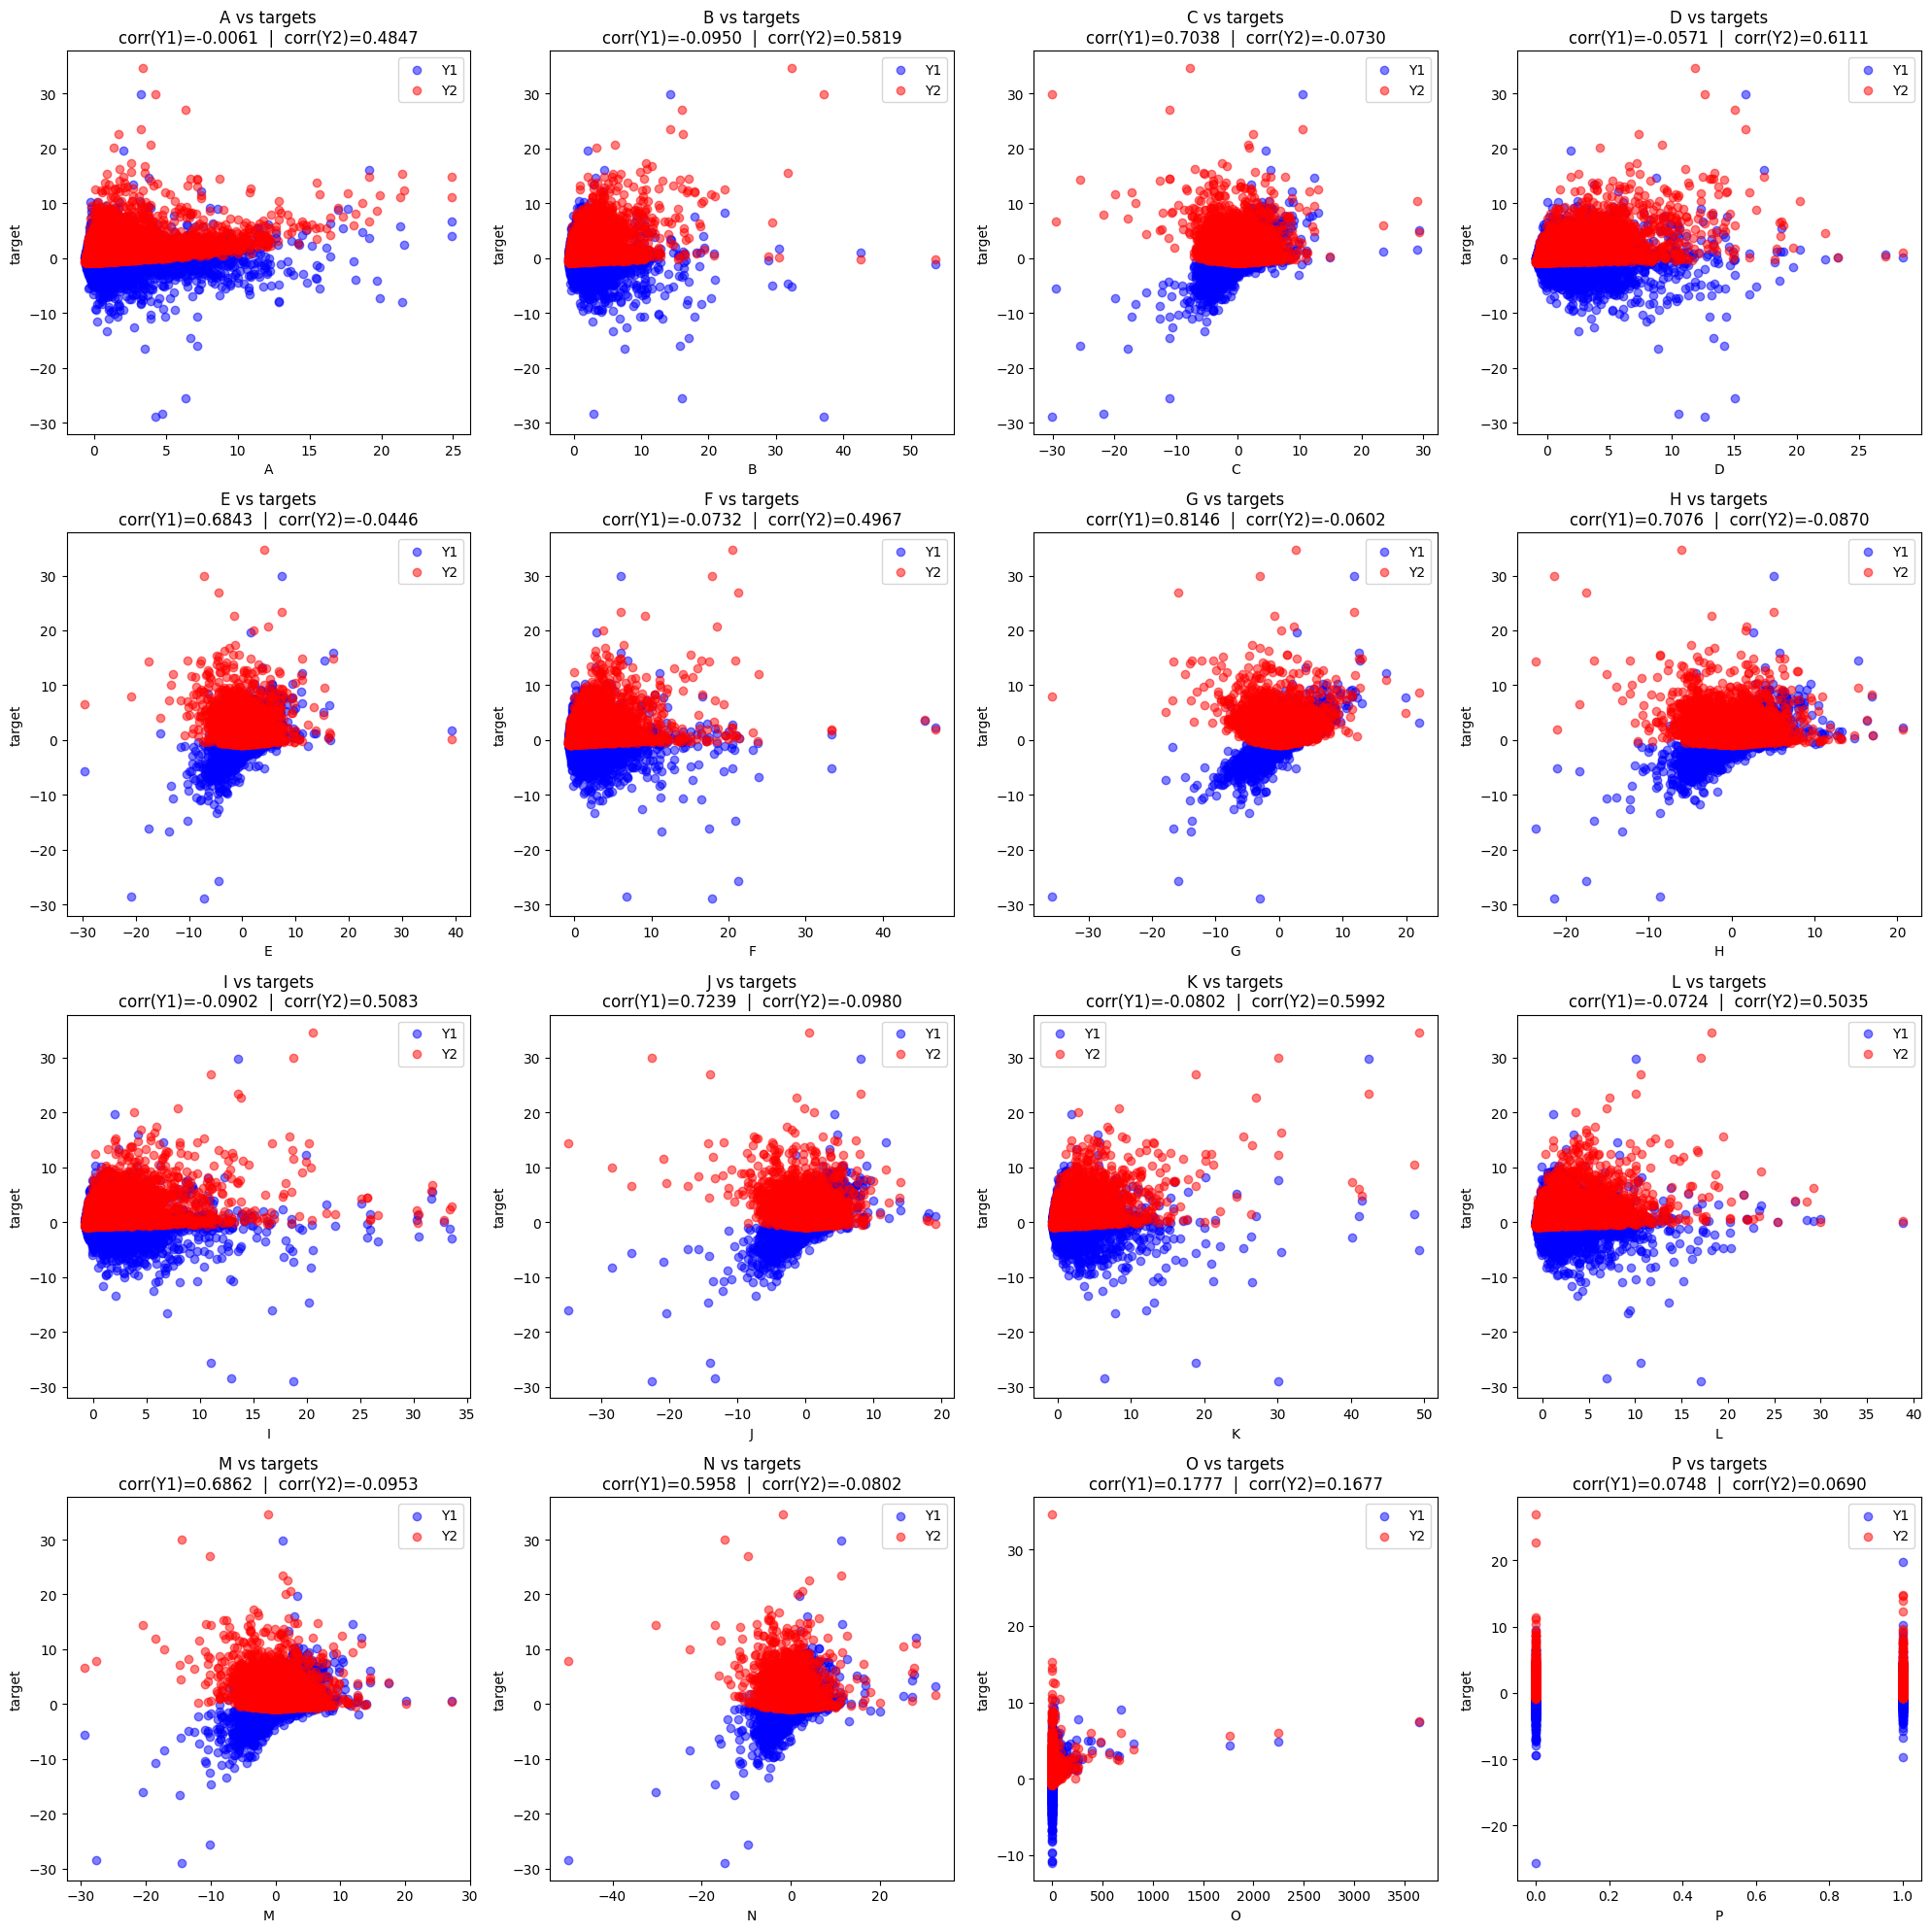

In [7]:
columns_to_plot = [c for c in columns if c not in ['time', 'Y1', 'Y2']]
num_cols = 4
num_rows = -(-len(columns_to_plot) // num_cols)
list_targets = [train_data["Y1"].to_numpy(),train_data["Y2"].to_numpy()]

correlation_dict_Y1 = plot_grid_vs_target(list_targets[0], "Y1", num_rows, num_cols, columns_to_plot, "blue")
print("\n")
correlation_dict_Y2 = plot_grid_vs_target(list_targets[1], "Y2", num_rows, num_cols, columns_to_plot, "red")
print("\n")
superpose_grids(list_targets, ["Y1","Y2"], num_rows, num_cols, columns_to_plot, ["blue","red"])

Compute Pearson correlation to assess linear relationship between the targets and the explanatory variables:

In [8]:
correlation_df = pd.DataFrame({
    'Correlation Y1': pd.Series(correlation_dict_Y1, dtype=float),
    'Correlation Y2': pd.Series(correlation_dict_Y2, dtype=float),
})
correlation_df = correlation_df.fillna(0.0)

# Helpful derived columns
correlation_df['abs_Y1'] = correlation_df['Correlation Y1'].abs()
correlation_df['abs_Y2'] = correlation_df['Correlation Y2'].abs()

# Combined strength (L2 norm of the two correlation coefficients)
correlation_df['score_l2'] = np.hypot(
    correlation_df['Correlation Y1'],
    correlation_df['Correlation Y2']
)

# Other combined scorings (pick the one you like)
correlation_df['score_max'] = correlation_df[['abs_Y1', 'abs_Y2']].max(axis=1)
correlation_df['score_mean'] = correlation_df[['abs_Y1', 'abs_Y2']].mean(axis=1)

# 1) Best features for Y1 (by absolute correlation with Y1)
top_by_Y1 = correlation_df.sort_values('abs_Y1', ascending=False)

# 2) Best features for Y2 (by absolute correlation with Y2)
top_by_Y2 = correlation_df.sort_values('abs_Y2', ascending=False)

# 3) Best overall considering both targets (L2 norm)
top_by_both = correlation_df.sort_values('score_l2', ascending=False).reset_index()
top_by_both = top_by_both.rename(columns={"index": "feature"})
pl_df = pl.from_pandas(top_by_both)

# Show results
print("Top by both (L2):\n")
print(pl_df.head(20))

Top by both (L2):

shape: (16, 8)
┌─────────┬───────────────┬──────────────┬──────────┬──────────┬──────────┬───────────┬────────────┐
│ feature ┆ Correlation   ┆ Correlation  ┆ abs_Y1   ┆ abs_Y2   ┆ score_l2 ┆ score_max ┆ score_mean │
│ ---     ┆ Y1            ┆ Y2           ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---        │
│ str     ┆ ---           ┆ ---          ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64        │
│         ┆ f64           ┆ f64          ┆          ┆          ┆          ┆           ┆            │
╞═════════╪═══════════════╪══════════════╪══════════╪══════════╪══════════╪═══════════╪════════════╡
│ G       ┆ 0.814568      ┆ -0.060187    ┆ 0.814568 ┆ 0.060187 ┆ 0.816788 ┆ 0.814568  ┆ 0.437377   │
│ J       ┆ 0.723921      ┆ -0.097986    ┆ 0.723921 ┆ 0.097986 ┆ 0.730522 ┆ 0.723921  ┆ 0.410953   │
│ H       ┆ 0.70756       ┆ -0.086976    ┆ 0.70756  ┆ 0.086976 ┆ 0.712885 ┆ 0.70756   ┆ 0.397268   │
│ C       ┆ 0.703823      ┆ -0.073009    ┆ 0.703823 ┆ 0.0

Many feature–target relations in the scatter plots look non-linear, so Pearson (linear) correlation can miss signal. Alternatives:
- Spearman's rho: rank-based; captures monotonic but non-linear relationships.
- Kendall's tau: rank-based; more robust to outliers but slower on large data.
- Mutual information (MI): model-free dependency measure; captures arbitrary non-linear relations (non-negative).
- Distance correlation / MIC (optional): require extra packages (e.g., `dcor`, `minepy`), useful for complex dependencies.

Below, compute Spearman, Kendall, and MI for each feature vs `Y1` and `Y2`, then rank features by these scores.

In [9]:
def rank_corr_series(X_col, y, method):
    m = X_col.notna() & y.notna()
    if m.sum() < 3:
        return np.nan
    if method == 'spearman':
        rho, _ = spearmanr(X_col[m], y[m])
        return rho
    elif method == 'kendall':
        tau, _ = kendalltau(X_col[m], y[m])
        return tau
    else:
        raise ValueError('method must be spearman or kendall')

In [10]:
# Prepare X (features) and y1, y2
feature_cols = [c for c in train_data.columns if c not in ['time']]
X = merged_data[feature_cols]
y1 = merged_data['Y1']
y2 = merged_data['Y2']

# Spearman and Kendall for all features
spearman_y1 = {c: rank_corr_series(X[c], y1, 'spearman') for c in feature_cols}
spearman_y2 = {c: rank_corr_series(X[c], y2, 'spearman') for c in feature_cols}
kendall_y1 = {c: rank_corr_series(X[c], y1, 'kendall') for c in feature_cols}
kendall_y2 = {c: rank_corr_series(X[c], y2, 'kendall') for c in feature_cols}

# Mutual Information (MI): requires numeric inputs; fill remaining NaNs to avoid failure
X_num = X.select_dtypes(include=['number']).copy()
# Minimal imputation (median) just for MI computation
X_num = X_num.fillna(X_num.median(numeric_only=True))
y1_filled = y1.fillna(y1.median())
y2_filled = y2.fillna(y2.median())

mi_y1 = mutual_info_regression(X_num.values, y1_filled.values, random_state=0)
mi_y2 = mutual_info_regression(X_num.values, y2_filled.values, random_state=0)
mi_y1 = pd.Series(mi_y1, index=X_num.columns)
mi_y2 = pd.Series(mi_y2, index=X_num.columns)

# Assemble results into a DataFrame
nl_df = pd.DataFrame({
    'spearman_Y1': pd.Series(spearman_y1),
    'spearman_Y2': pd.Series(spearman_y2),
    'kendall_Y1': pd.Series(kendall_y1),
    'kendall_Y2': pd.Series(kendall_y2),
}).fillna(0.0)

# Insert MI columns (only for numeric features) and fill others with 0
nl_df['MI_Y1'] = 0.0
nl_df['MI_Y2'] = 0.0
for col in X_num.columns:
    nl_df.loc[col, 'MI_Y1'] = mi_y1[col]
    nl_df.loc[col, 'MI_Y2'] = mi_y2[col]

# Build combined ranking scores
nl_df['rank_strength_Y1'] = nl_df['spearman_Y1'].abs().rank(ascending=False, method='average')
nl_df['rank_strength_Y2'] = nl_df['spearman_Y2'].abs().rank(ascending=False, method='average')
nl_df['rank_MI_Y1'] = nl_df['MI_Y1'].rank(ascending=False, method='average')
nl_df['rank_MI_Y2'] = nl_df['MI_Y2'].rank(ascending=False, method='average')
nl_df['rank_overall'] = (nl_df['rank_strength_Y1'] + nl_df['rank_MI_Y1'] + nl_df['rank_strength_Y2'] + nl_df['rank_MI_Y2']) / 4.0
nl_df_reset = nl_df.reset_index()
nl_df_reset = nl_df_reset.rename(columns={"index": "feature"})
nl_pl = pl.from_pandas(nl_df_reset)
print("CORRELATIONS WITH RANKING")
print(nl_pl)

# Sort views
top_spearman_Y1 = pl.from_pandas(nl_df.sort_values('spearman_Y1', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_spearman_Y2 =  pl.from_pandas(nl_df.sort_values('spearman_Y2', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y1 =  pl.from_pandas(nl_df.sort_values('MI_Y1', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y2 =  pl.from_pandas(nl_df.sort_values('MI_Y2', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_overall =  pl.from_pandas(nl_df.sort_values('rank_overall').head(20).reset_index().rename(columns={"index": "feature"}))

print('\nTop Spearman (Y1):\n')
print(top_spearman_Y1[:,['feature','spearman_Y1']])
print('\nTop Spearman (Y2):\n')
print(top_spearman_Y2[:,['feature','spearman_Y2']])
print('\nTop Mutual Information (Y1):\n')
print(top_mi_Y1[:,['feature','spearman_Y1']])
print('\nTop Mutual Information (Y2):\n')
print(top_mi_Y2[:,['feature','spearman_Y2']])
print('\nTop Overall (avg rank of Spearman & MI for Y1 and Y2):\n')
print(top_overall[:,['feature','spearman_Y1','spearman_Y2']])

CORRELATIONS WITH RANKING
shape: (18, 12)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ feature ┆ spearman_Y ┆ spearman_ ┆ kendall_Y ┆ … ┆ rank_stre ┆ rank_MI_Y ┆ rank_MI_Y ┆ rank_over │
│ ---     ┆ 1          ┆ Y2        ┆ 1         ┆   ┆ ngth_Y2   ┆ 1         ┆ 2         ┆ all       │
│ str     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ A       ┆ -0.002308  ┆ 0.609209  ┆ -0.00138  ┆ … ┆ 5.0       ┆ 14.0      ┆ 2.0       ┆ 9.75      │
│ B       ┆ -0.021435  ┆ 0.62362   ┆ -0.013819 ┆ … ┆ 3.0       ┆ 12.0      ┆ 4.0       ┆ 8.25      │
│ C       ┆ 0.695609   ┆ -0.00963  ┆ 0.522716  ┆ … ┆ 17.0      ┆ 5.0       ┆ 12.0      ┆ 10.0      │
│ D       ┆ -0.016948  ┆ 0.612065  ┆ -0.011279 ┆ 

### 4) Visualize Relationships among Explanatory Variables

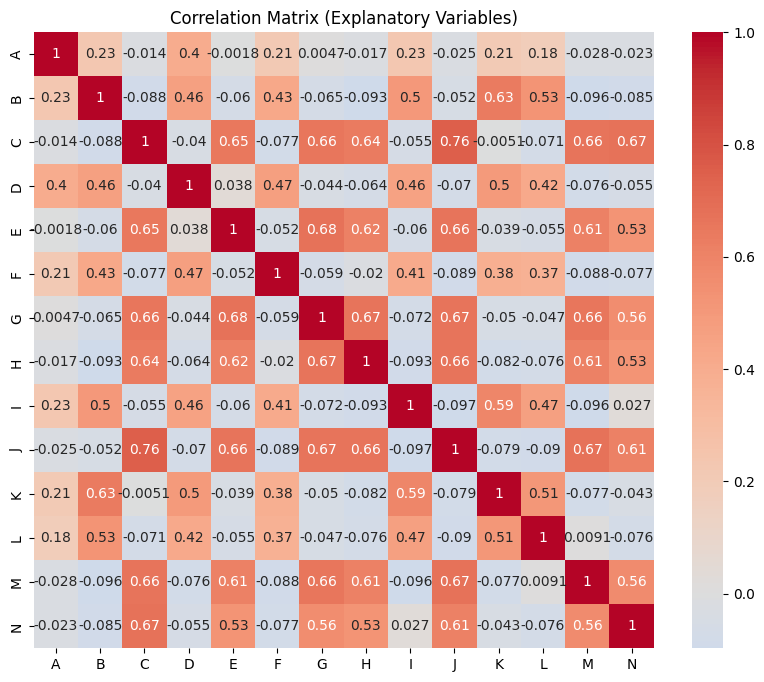

In [33]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

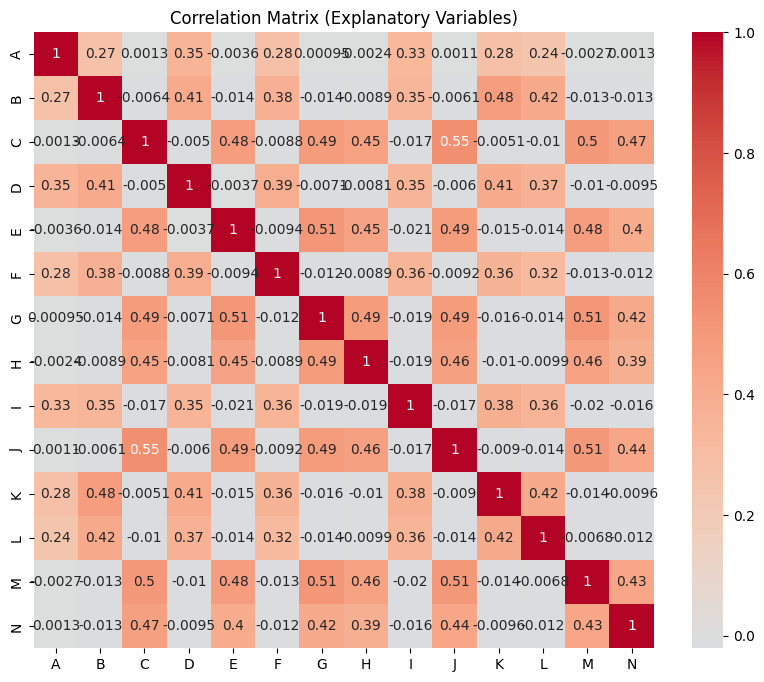

In [34]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="kendall")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

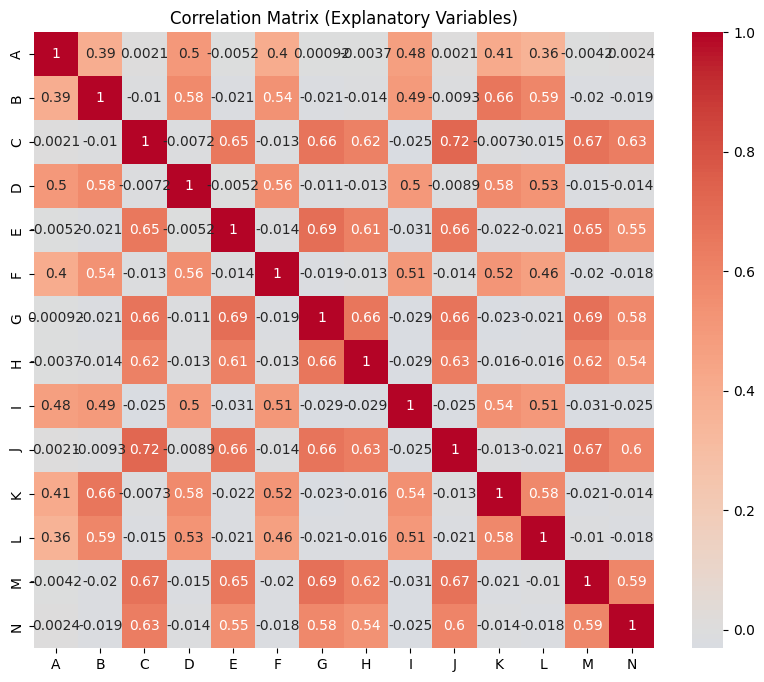

In [35]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="spearman")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

### 5) Visualize Distributions

Now compute the histograms deleting the outlier to see distributions better

In [14]:
def generate_hist(df: pl.DataFrame, bins: int = 100, cols: int = 4, clip_mode: str = "quantile", q_low: float = 0.01, q_high: float = 0.99, iqr_k: float = 1.5, log_y: bool = False):

    feature_cols = [c for c in df.columns]
    n = len(feature_cols)

    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(feature_cols):
        ax = axes[i]

        s = pd.to_numeric(df[col].to_pandas(), errors="coerce").dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        if clip_mode == "quantile":
            low, high = s.quantile(q_low), s.quantile(q_high)
        else:  # IQR
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            low, high = q1 - iqr_k * iqr, q3 + iqr_k * iqr

        s_clipped = s[(s >= low) & (s <= high)]
        clipped_pct = 0.0 if len(s) == 0 else 100.0 * (1.0 - len(s_clipped) / len(s))

        ax.hist(s_clipped,bins=bins,color="steelblue",alpha=0.9,edgecolor="white",density=True)

        ax.set_title(
            f"Histogram of {col}\n[{low:.3g}, {high:.3g}] | outlier pct {clipped_pct:.3f}%"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.set_xlim(low, high)

        if log_y:
            ax.set_yscale("log")

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


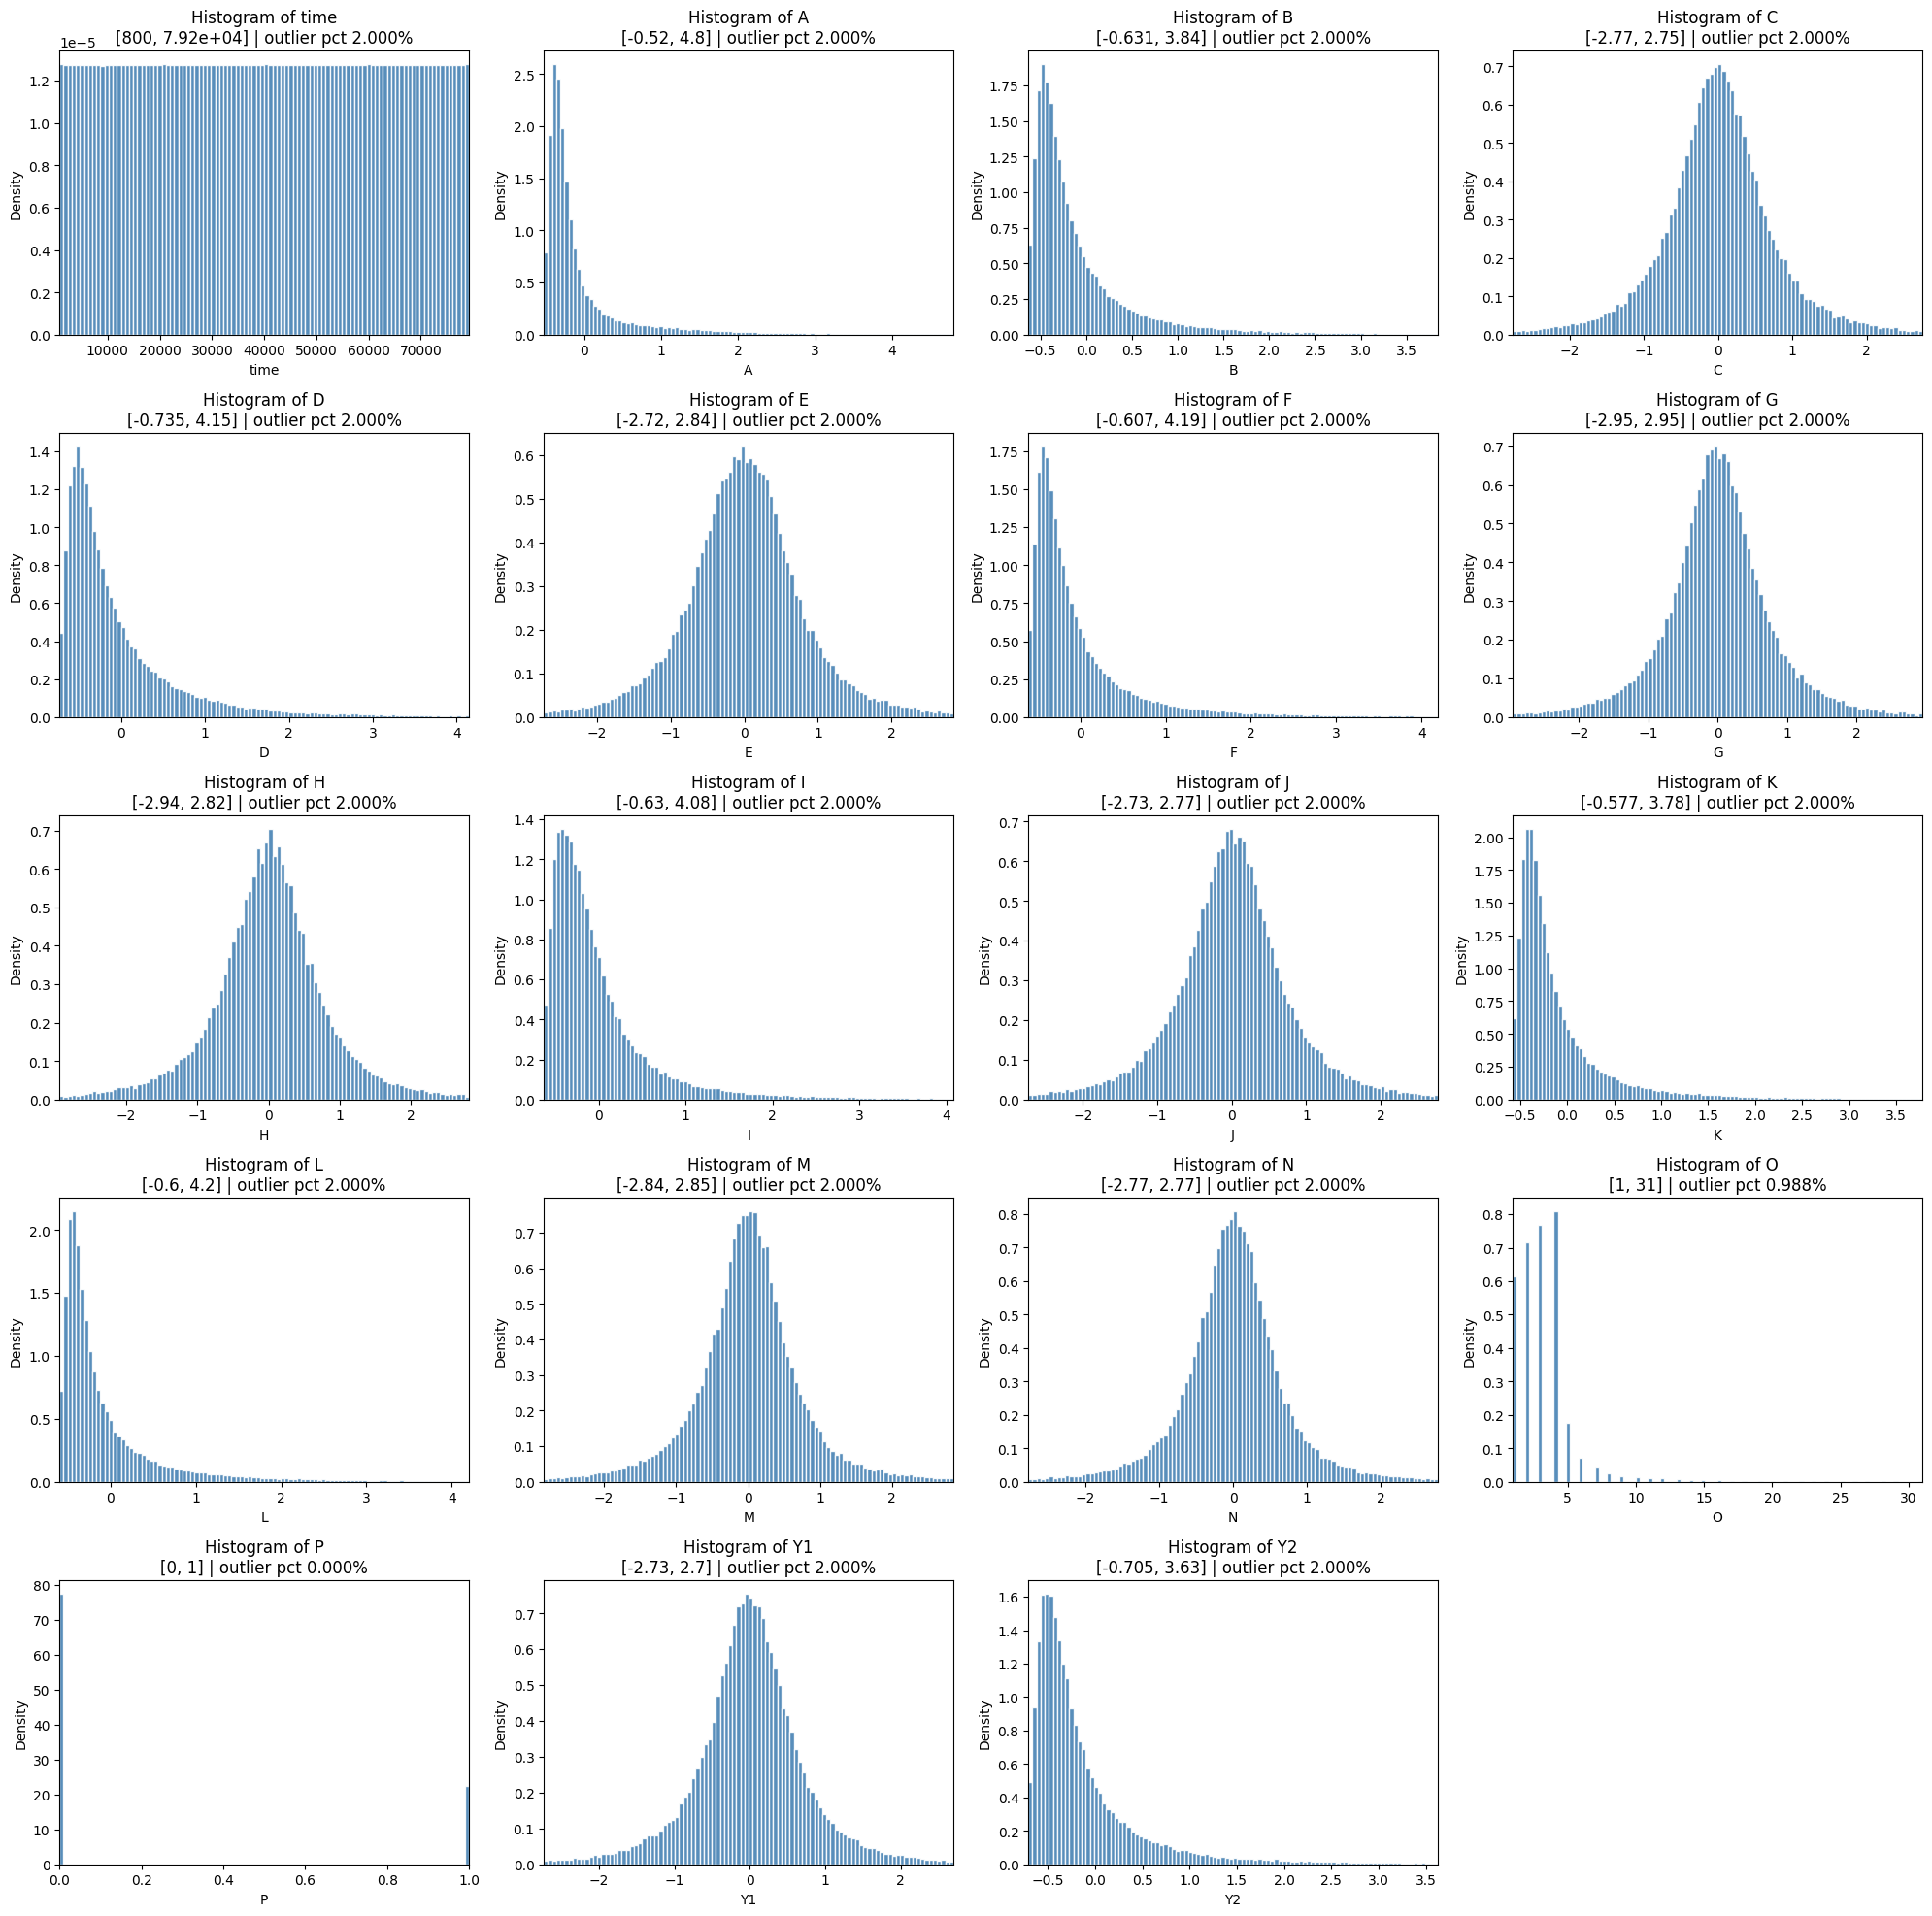

In [15]:
generate_hist(train_data, log_y=False)

### 6) Get important Statistics

In [16]:
def test_stationarity(series, signif=0.05):
    """
    Ejecuta ADF y KPSS para una serie (pandas Series).
    """
    results = {}
    
    # ADF Test
    adf_res = adfuller(series.dropna(), autolag='AIC')
    results['ADF_stat'] = adf_res[0]
    results['ADF_pval'] = adf_res[1]
    results['ADF_stationary'] = adf_res[1] < signif
    
    # KPSS Test
    try:
        kpss_res = kpss(series.dropna(), regression='c', nlags="auto")
        results['KPSS_stat'] = kpss_res[0]
        results['KPSS_pval'] = kpss_res[1]
        results['KPSS_stationary'] = kpss_res[1] > signif
    except:
        results['KPSS_stat'] = None
        results['KPSS_pval'] = None
        results['KPSS_stationary'] = None
    
    return results


In [17]:
train_data.describe()

shape: (9, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ statistic ┆ time      ┆ A         ┆ B         ┆ … ┆ O         ┆ P        ┆ Y1        ┆ Y2        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ count     ┆ 80000.0   ┆ 80000.0   ┆ 80000.0   ┆ … ┆ 15993.0   ┆ 15994.0  ┆ 80000.0   ┆ 80000.0   │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 64007.0   ┆ 64006.0  ┆ 0.0       ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ mean      ┆ 40003.926 ┆ 0.068979  ┆ -0.004927 ┆ … ┆ 4.789908  ┆ 0.224959 ┆ -0.002807 ┆ -0.061172 │
│           ┆ 125       ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ std       ┆ 23095.035 ┆ 1.078271  ┆ 1.031053  ┆ … ┆ 40.194609 ┆ 0.417569 ┆ 0.970655  ┆ 0.923702  │
│           ┆ 045       ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ min       ┆ 0.0       ┆ -0.642788 ┆ -0.771179 ┆ … ┆ 1.0       ┆ 0.0      ┆ -28.91818 ┆ -0.850799 │
│ 25%       ┆ 20005.0   ┆ -0.37417  ┆ -0.451917 ┆ … ┆ 2.0       ┆ 0.0      ┆ -0.387517 ┆ -0.497795 │
│ 50%       ┆ 40005.0   ┆ -0.264494 ┆ -0.285344 ┆ … ┆ 3.0       ┆ 0.0      ┆ -0.00158  ┆ -0.318087 │
│ 75%       ┆ 60004.0   ┆ 0.005446  ┆ 0.061002  ┆ … ┆ 4.0       ┆ 0.0      ┆ 0.392468  ┆ 0.026902  │
│ max       ┆ 80004.0   ┆ 24.917549 ┆ 53.667013 ┆ … ┆ 3645.0    ┆ 1.0      ┆ 29.859458 ┆ 34.636039 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴──────────┴───────────┴───────────┘

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


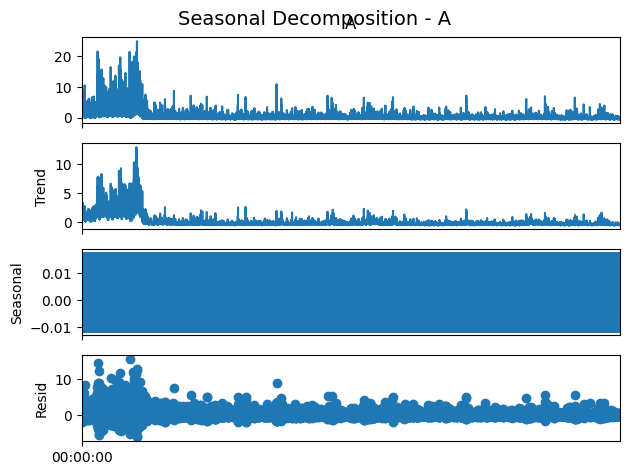

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


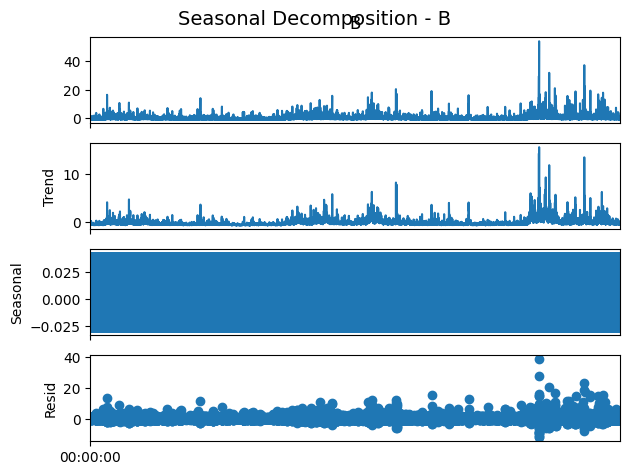

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


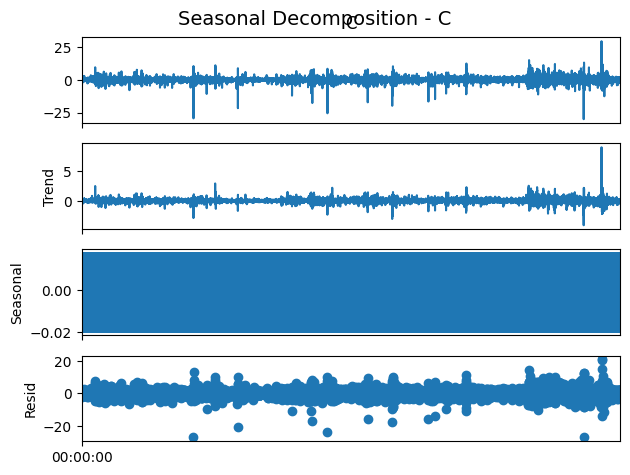

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


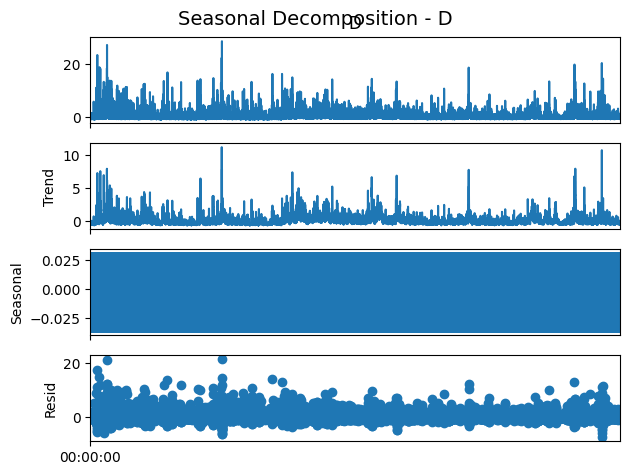

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


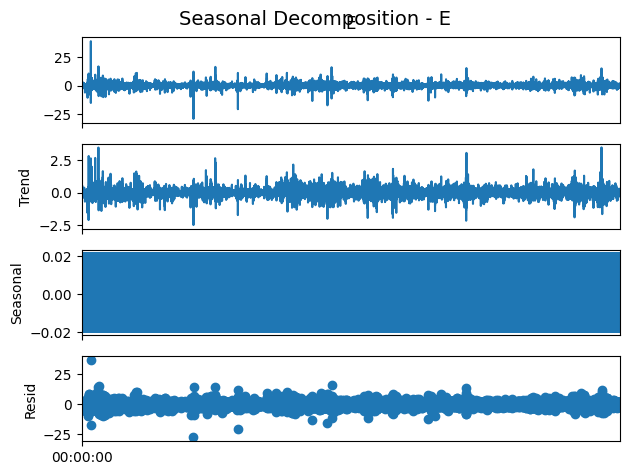

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


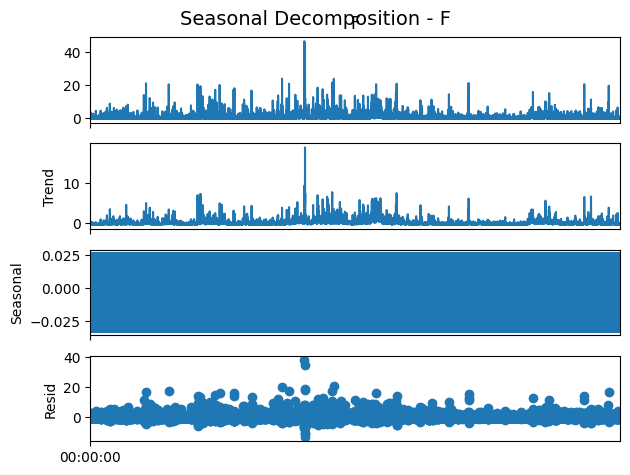

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


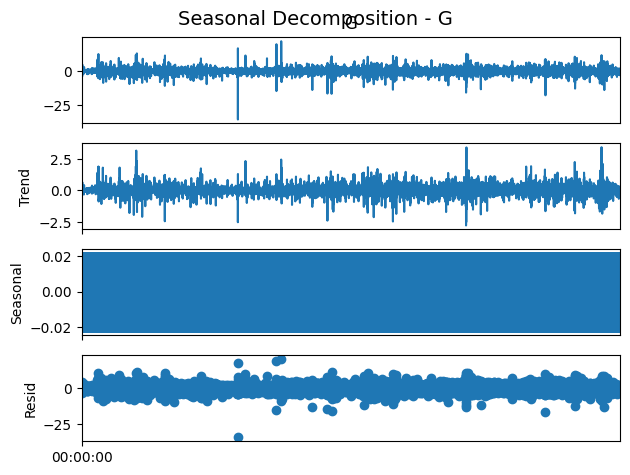

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


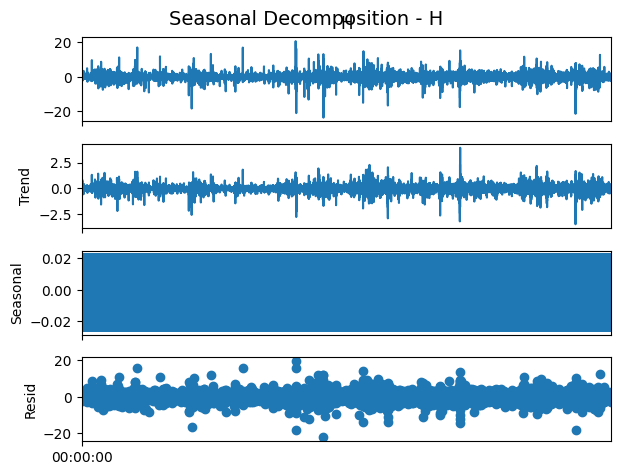

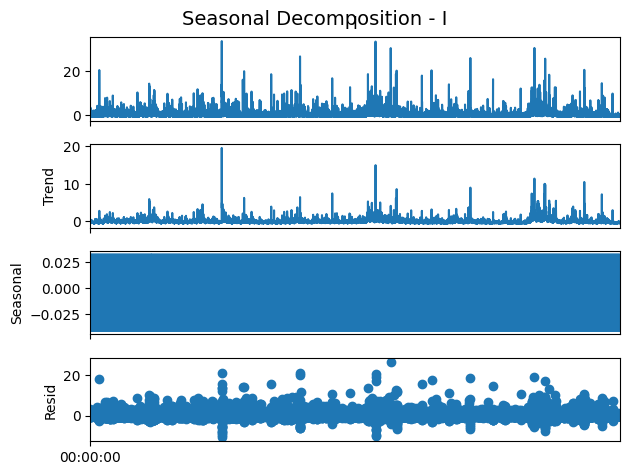

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


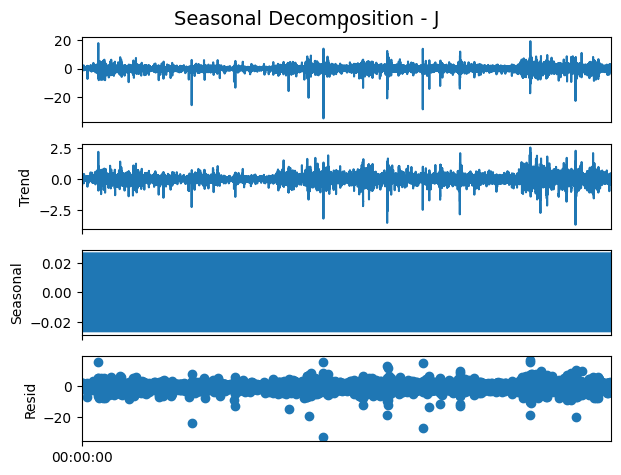

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


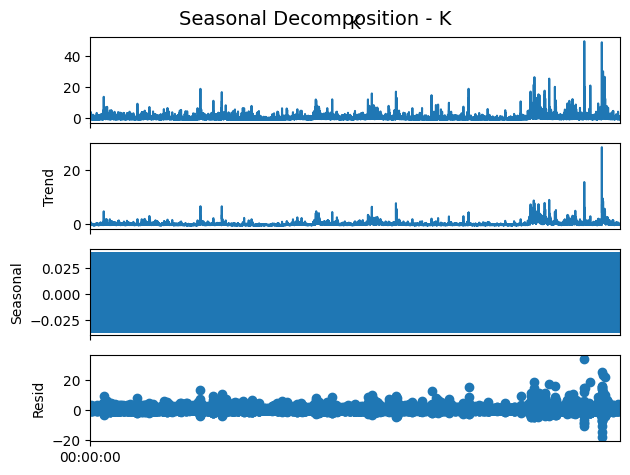

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


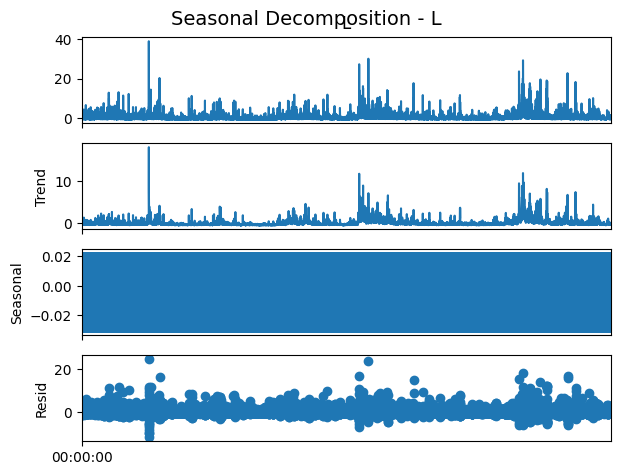

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


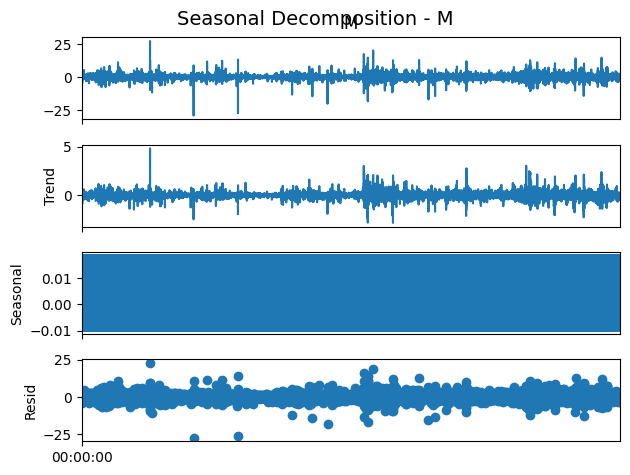

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


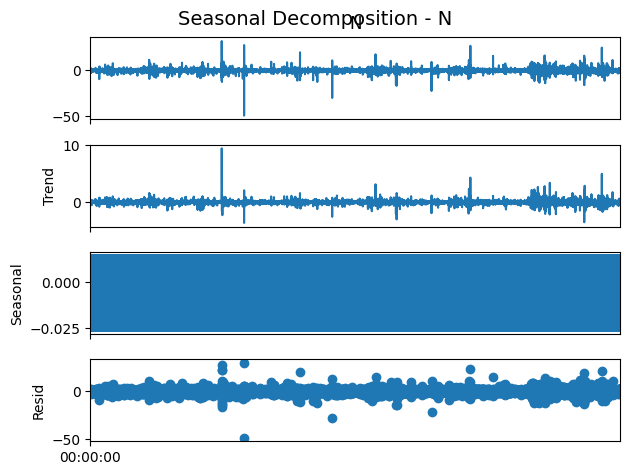

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


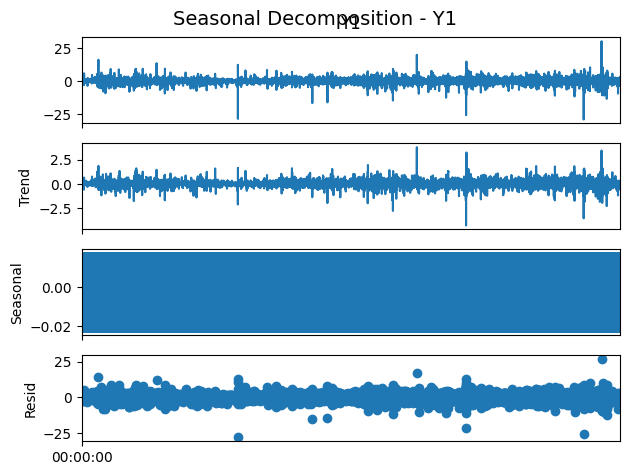

C:\Users\Iker\AppData\Local\Temp\ipykernel_13764\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


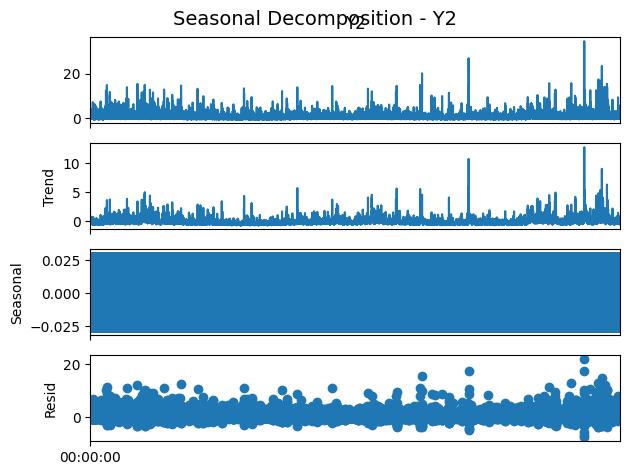

      ADF_stat ADF_pval ADF_stationary  KPSS_stat KPSS_pval KPSS_stationary
A   -10.933085      0.0           True  14.390477      0.01           False
B    -16.42802      0.0           True   5.533782      0.01           False
C   -46.622011      0.0           True   0.136151       0.1            True
D   -18.943366      0.0           True    1.20088      0.01           False
E   -38.064168      0.0           True   0.222299       0.1            True
F    -18.66096      0.0           True   2.270067      0.01           False
G   -82.229956      0.0           True   0.110466       0.1            True
H  -101.808361      0.0           True   0.190704       0.1            True
I   -19.550593      0.0           True   0.450267  0.055488            True
J  -101.133482      0.0           True   0.068527       0.1            True
K   -17.093981      0.0           True   5.279614      0.01           False
L   -15.149314      0.0           True   3.135277      0.01           False
M   -35.9324

In [18]:
excluded = ["O","P"]

pdf = train_data.to_pandas()

time = pd.to_datetime(pdf["time"])
pdf = pdf.set_index(time)

summary_stats = {}

for col in pdf.columns:
    if col in excluded or col == "time":
        continue
    
    series = pdf[col].dropna()
    
    results = test_stationarity(series)
    summary_stats[col] = results

    try:
        decomp = seasonal_decompose(series, model='additive', period=12)
        fig = decomp.plot()
        fig.suptitle(f"Seasonal Decomposition - {col}", fontsize=14)
        plt.show()
    except Exception as e:
        print(f"⚠️ No se pudo descomponer {col}: {e}")

summary_df = pd.DataFrame(summary_stats).T
print(summary_df)

### 7) Outlier Treatment

In [46]:
def run_pyod_on_polars(
    df: pl.DataFrame,
    cols: list[str] | None = None,
    model: str = "copod",         
    contamination: float = 0.05,
    scale: bool = True,           
    suffix: str = ""
) -> pl.DataFrame:
    if cols is None:
        cols = df.select(cs.numeric()).columns
    X = df.select(cols).to_numpy()

    is_finite = np.isfinite(X).all(axis=1)
    X_clean = X[is_finite]

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_clean = scaler.fit_transform(X_clean)

    if model.lower() == "copod":
        clf = COPOD(contamination=contamination)
    elif model.lower() == "iforest":
        clf = IForest(contamination=contamination, random_state=42)

    clf.fit(X_clean)
    scores_clean = clf.decision_function(X_clean)  # mayor = más outlier
    labels_clean = clf.predict(X_clean)

    scores = np.full(shape=(len(df),), fill_value=np.nan, dtype=float)
    labels = np.full(shape=(len(df),), fill_value=np.nan, dtype=float)

    scores[is_finite] = scores_clean
    labels[is_finite] = labels_clean

    out = df.with_columns(
        pl.Series(f"outlier_score{suffix}", scores),
        pl.Series(f"is_outlier{suffix}", labels).cast(pl.Int8, strict=False)
    )
    return out

In [47]:
mask_time = [c for c in train_data_1.columns if c not in ['time']]
df_scored_all = run_pyod_on_polars(pl.DataFrame(train_data_1[mask_time]), model="copod", contamination=0.02)
df_scored_targets = run_pyod_on_polars(pl.DataFrame(train_data_1[["Y1","Y2"]]), model="copod", contamination=0.02)

dfs_scored = {"all": df_scored_all, "targets": df_scored_targets}

mask_all = df_scored_all["is_outlier"] == 0
mask_targets = df_scored_targets["is_outlier"] == 0
df_clean_all = train_data.filter(mask_all)
df_clean_targets = train_data.filter(mask_targets)

dfs_to_use = {"all": df_clean_all, "targets": df_clean_targets, "none": train_data}

for i in dfs_to_use.values():
    print(i,"\n")


shape: (78_400, 19)
┌───────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ time  ┆ A         ┆ B         ┆ C         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ i64   ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0     ┆ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.935902 ┆ -0.310081 │
│ 1     ┆ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.089707 ┆ -0.305374 │
│ 2     ┆ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.077855 ┆ -0.631485 │
│ 3     ┆ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ … ┆ -1.0 ┆ 0.0  ┆ 0.941271  ┆ -0.535212 │
│ 4     ┆ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.039582 ┆ -0.490561 │
│ …     ┆ …         ┆ …         ┆ …         ┆ … ┆ …    ┆ …    ┆ …         ┆ …         │
│ 80000 ┆ -0

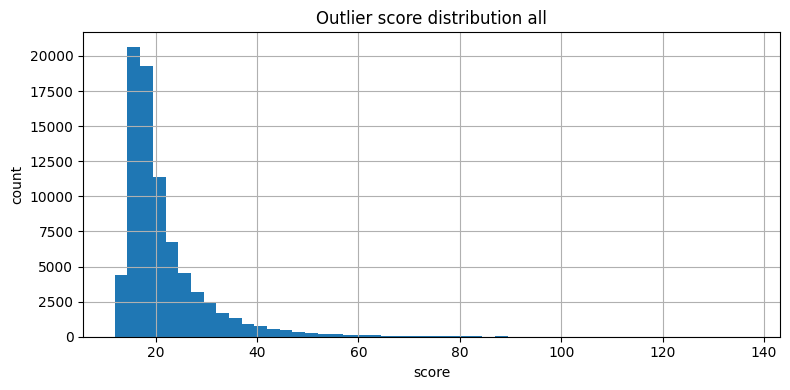

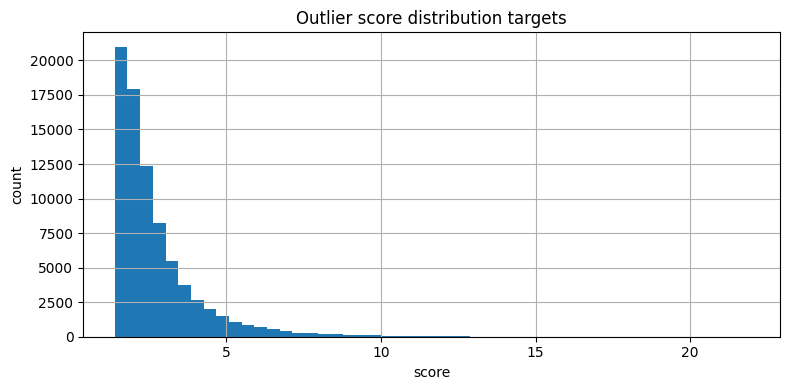

In [48]:
for label, i in dfs_scored.items():

    pdf = i.select(["outlier_score","is_outlier"]).to_pandas()

    plt.figure(figsize=(8,4))
    pdf["outlier_score"].hist(bins=50)
    plt.title(f"Outlier score distribution {label}")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

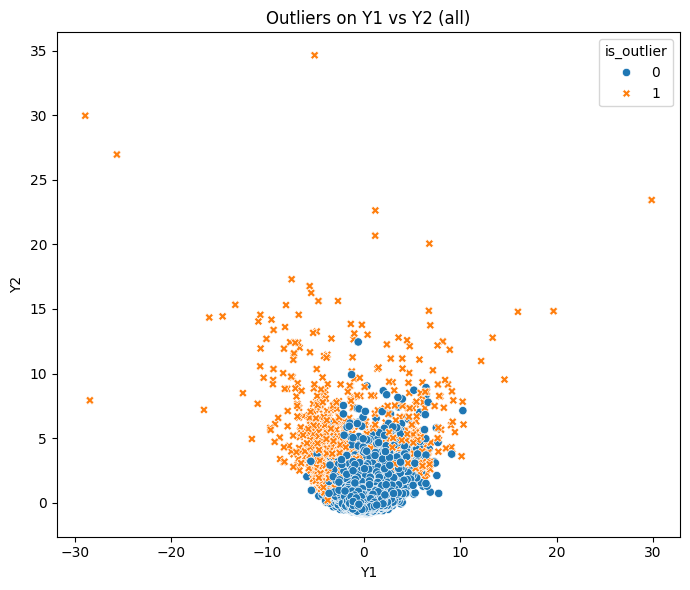

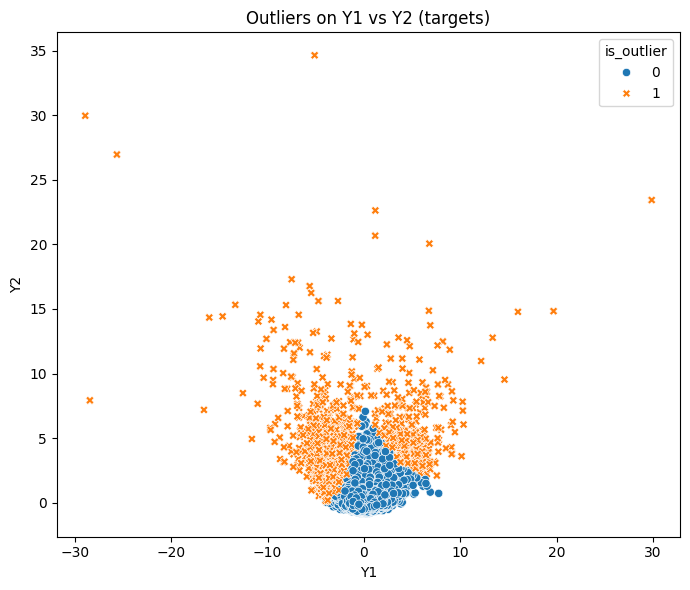

In [49]:
feat_x, feat_y = "Y1", "Y2"   # cámbialos

for label, i in dfs_scored.items():
    pdf2 = i.select([feat_x, feat_y, "is_outlier"]).to_pandas()

    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=pdf2,
        x=feat_x, y=feat_y,
        hue="is_outlier", style="is_outlier"
    )
    plt.title(f"Outliers on {feat_x} vs {feat_y} ({label})")
    plt.tight_layout()
    plt.show()

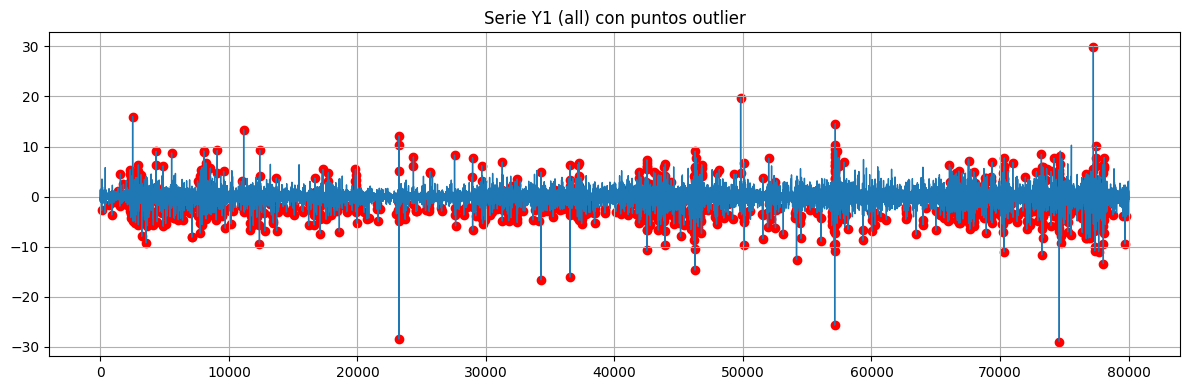

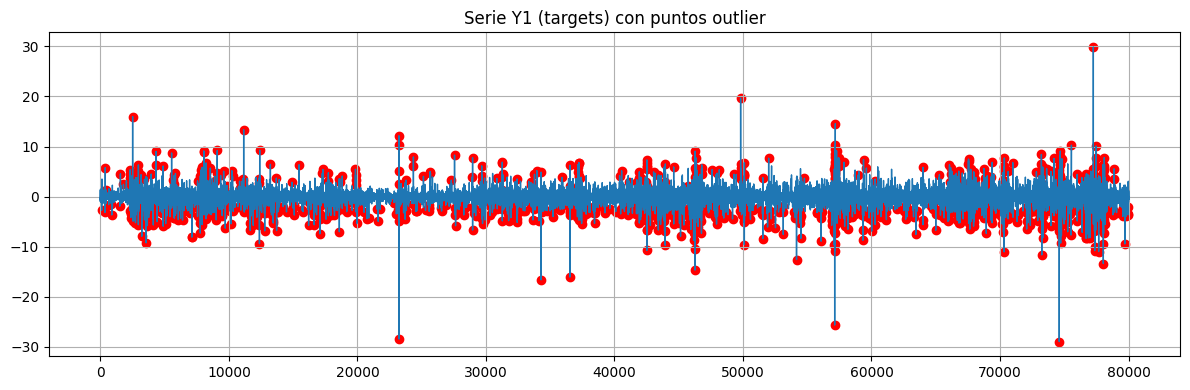

In [50]:
for label, i in dfs_scored.items():

    # añadir índice explícito en Polars
    i_idx = i.with_row_index("row_idx")

    # pasar a pandas
    pdf_ts = i_idx.select(["row_idx","Y1","Y2","is_outlier"]).to_pandas()

    # plot serie completa
    plt.figure(figsize=(12,4))
    plt.plot(train_data["time"].to_pandas(), pdf_ts["Y1"], linewidth=1)

    # seleccionar outliers
    sel = pdf_ts["is_outlier"] == 1

    # scatter en posiciones outlier
    plt.scatter(
        train_data["time"].to_pandas().iloc[pdf_ts.loc[sel,"row_idx"]],
        pdf_ts.loc[sel,"Y1"],
        marker="o", color="red"
    )

    plt.title(f"Serie Y1 ({label}) con puntos outlier")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


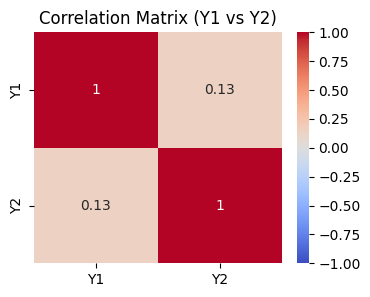

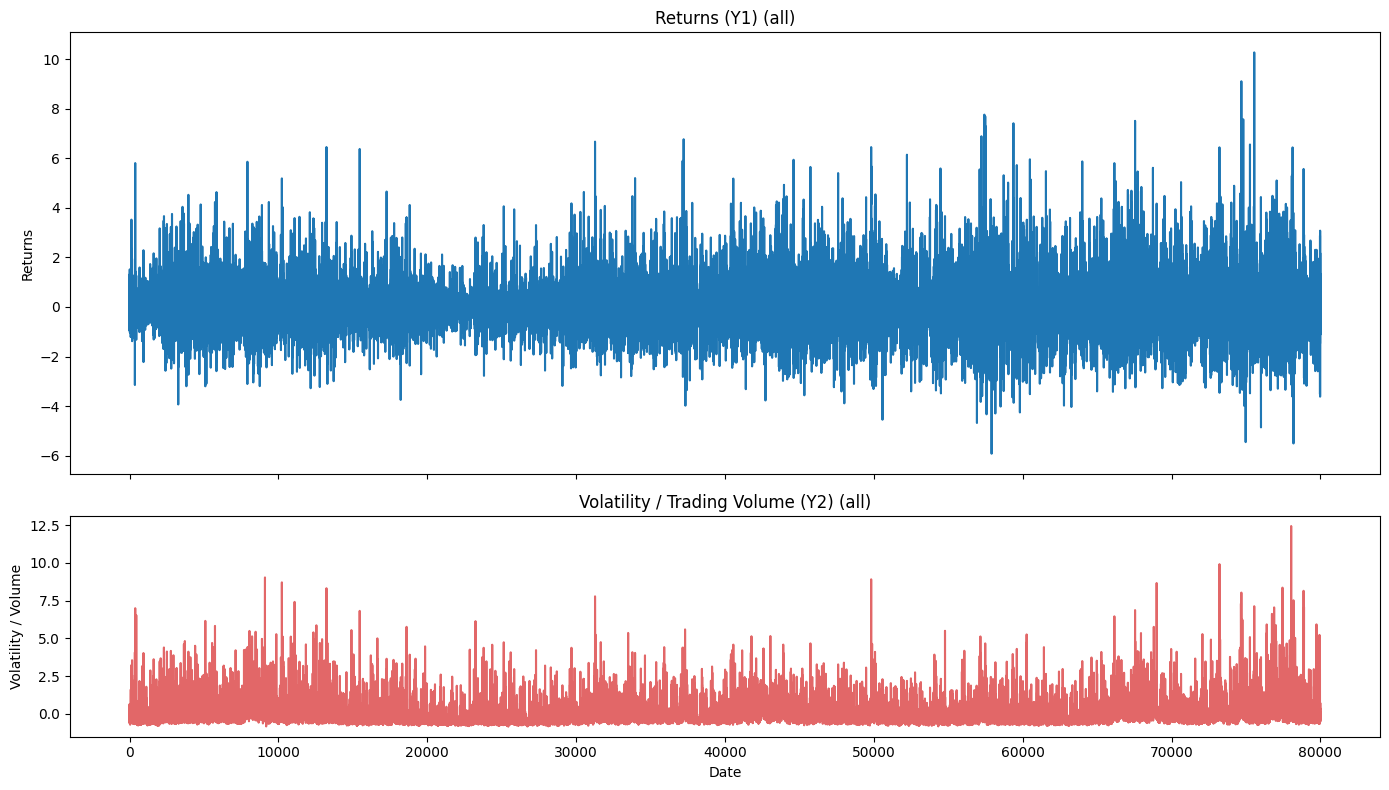

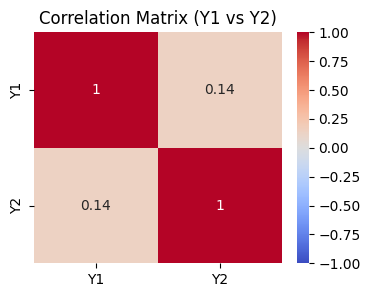

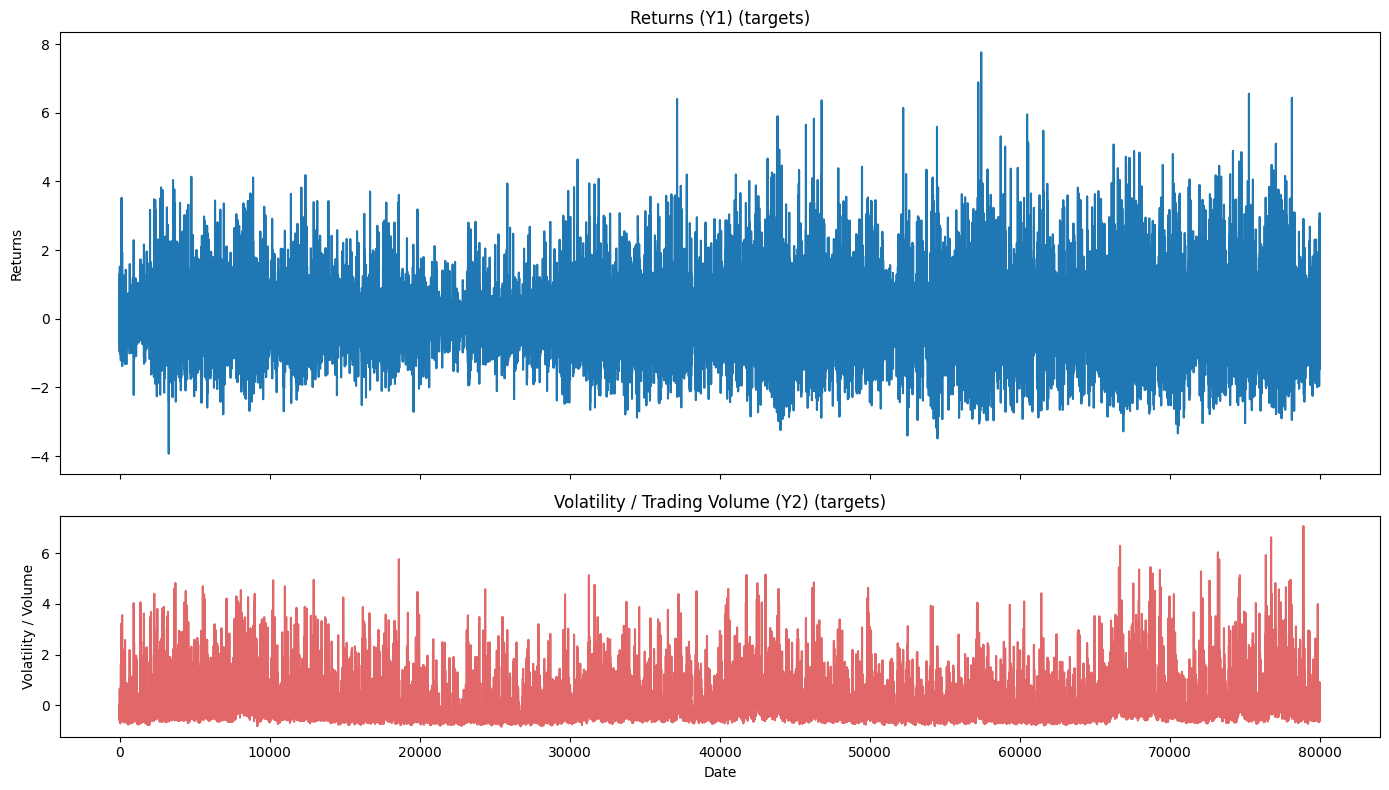

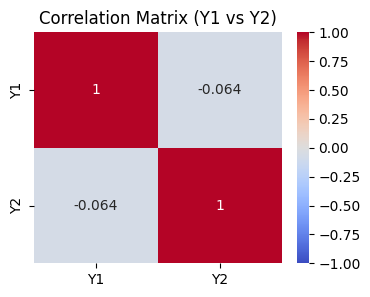

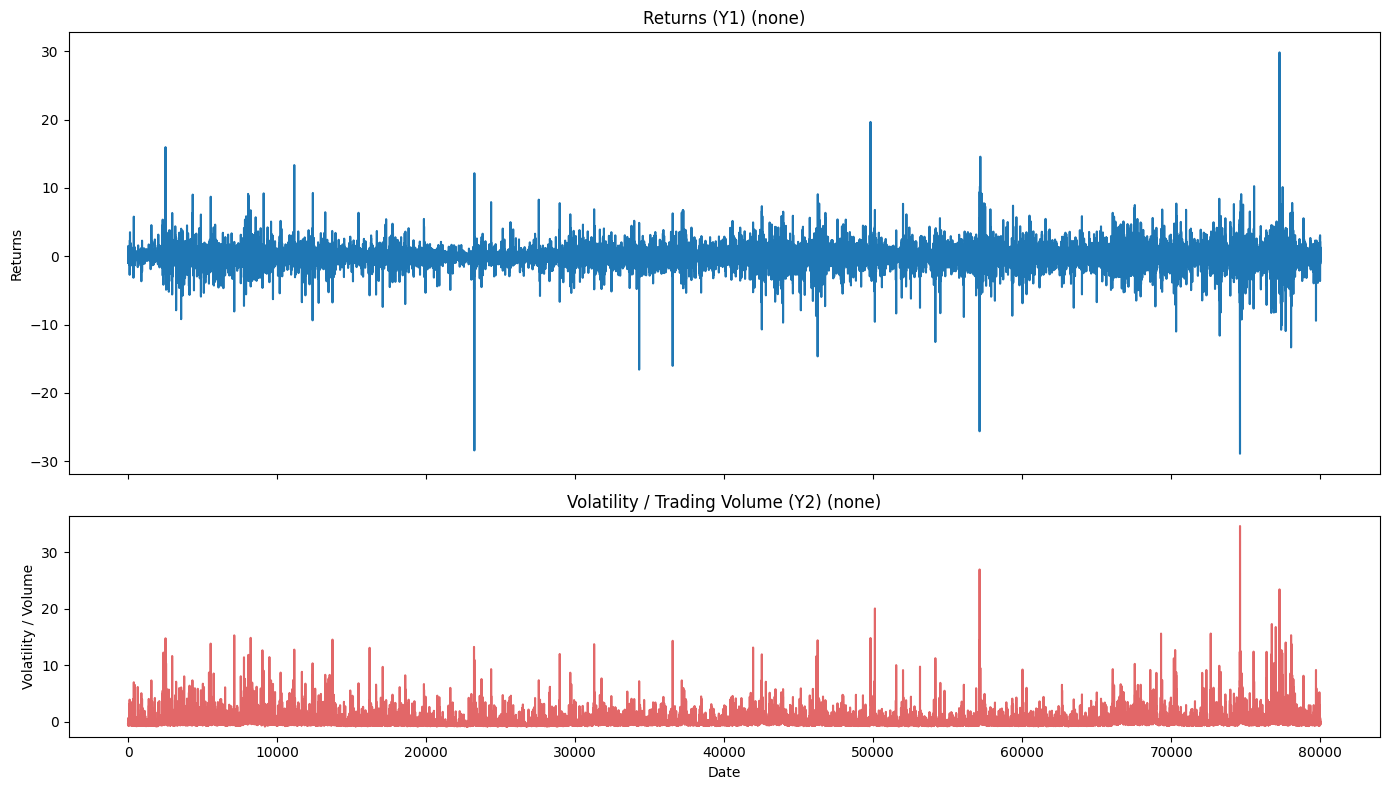

In [51]:
for label, i in dfs_to_use.items():

    pdf = i.select(["time","Y1","Y2"]).to_pandas()

    corr_matrix = pdf[["Y1", "Y2"]].corr(method="pearson")

    plt.figure(figsize=(4,3))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix (Y1 vs Y2)")
    plt.show()
    print("\n")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[2,1]})

    # Rendimientos arriba
    ax1.plot(pdf["time"], pdf["Y1"], color="tab:blue")
    ax1.set_ylabel("Returns")
    ax1.set_title(f"Returns (Y1) ({label})")

    # Volatilidad/volumen abajo
    ax2.plot(pdf["time"], pdf["Y2"], color="tab:red", alpha=0.7)
    ax2.set_ylabel("Volatility / Volume")
    ax2.set_xlabel("Date")
    ax2.set_title(f"Volatility / Trading Volume (Y2) ({label})")

    plt.tight_layout()
    plt.show()

### 8) Time Series Statistical Analysis

Provide analysis for Y1:

In [52]:
for label, df in dfs_to_use.items():

    y_col = "Y1"
    drop_cols = ["O","P"] 
    exog_cols = [c for c in df.columns if c not in ["time", y_col, *drop_cols]]

    pdf = df.select(["time", y_col, *exog_cols]).to_pandas()
    pdf["time"] = pd.to_datetime(pdf["time"])
    pdf = pdf.set_index("time").sort_index()

    y = pdf[y_col]
    X = pdf[exog_cols]

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=X.columns
    )

### 9) ML Models

In [53]:
# -----------------------------
# Utilidades
# -----------------------------
def _prepare_xy_from_polars(
    df_pl: pl.DataFrame,
    target_col: str,
    drop_cols: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Toma un pl.DataFrame y devuelve (X_pd, y_pd, feature_names)
    - solo columnas numéricas
    - elimina cols en drop_cols
    - elimina filas con NaN/Inf
    """
    if drop_cols is None:
        drop_cols = []

    # solo numéricas + target si fuera string
    num_cols = [c for c, dt in zip(df_pl.columns, df_pl.dtypes) if dt.is_numeric()]
    cols = [c for c in num_cols if c not in drop_cols]

    if target_col not in df_pl.columns:
        raise ValueError(f"Target '{target_col}' no está en el DataFrame.")

    # Asegurar que target es numérico
    if target_col not in cols:
        cols = [*cols, target_col]

    pdf = df_pl.select(cols).to_pandas()

    # limpiar NaN/Inf
    pdf = pdf.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

    y = pdf[target_col]
    X = pdf.drop(columns=[target_col])
    feature_names = list(X.columns)
    return X, y, feature_names


def _cv_mae_timeseries(model, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> float:
    """
    MAE medio con TimeSeriesSplit. Reentrena y evalúa en cada fold.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes = []
    for tr, va in tscv.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        maes.append(mean_absolute_error(y.iloc[va], pred))
    return float(np.mean(maes)) if maes else np.nan


def _fit_rf_and_importances(
    X: pd.DataFrame,
    y: pd.Series,
    n_estimators: int = 400,
    max_depth: Optional[int] = None,
    random_state: int = 42,
    compute_permutation: bool = True,
    perm_scoring: str = "neg_mean_absolute_error",
    perm_repeats: int = 10,
) -> Tuple[RandomForestRegressor, np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Entrena RF y devuelve:
      - modelo
      - importancias Gini (array shape [n_features])
      - perm_importance.mean, perm_importance.std (o None si no se calcula)
    """
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1,
    )
    rf.fit(X, y)
    gini = rf.feature_importances_

    perm_mean = perm_std = None
    if compute_permutation:
        perm = permutation_importance(
            rf, X, y,
            scoring=perm_scoring,
            n_repeats=perm_repeats,
            random_state=random_state,
            n_jobs=-1,
        )
        perm_mean = perm.importances_mean
        perm_std = perm.importances_std
    return rf, gini, perm_mean, perm_std


def analyze_rf_importances_for_dict(
    dfs_to_use: Dict[str, pl.DataFrame],
    target_col: str = "y",
    drop_cols: Optional[List[str]] = None,
    n_estimators: int = 400,
    max_depth: Optional[int] = None,
    compute_permutation: bool = True,
    n_splits_cv: int = 5,
    top_k_plot: int = 20,
    do_plots: bool = True,
) -> pl.DataFrame:
    """
    Recorre un dict {nombre: pl.DataFrame}, entrena RF y devuelve un pl.DataFrame largo con:
      dataset, feature, gini_importance, perm_mean, perm_std, rank_gini, rank_perm, mae_cv

    Si do_plots=True, dibuja top_k de importancias por dataset.
    """
    all_records = []

    for name, df_pl in dfs_to_use.items():
        # 1) preparar X,y
        X, y, feature_names = _prepare_xy_from_polars(df_pl, target_col=target_col, drop_cols=drop_cols)

        if len(feature_names) == 0:
            print(f"[{name}] No hay features numéricas para entrenar.")
            continue
        if len(X) < 30:
            print(f"[{name}] Muy pocas filas ({len(X)}). Saltando.")
            continue

        # 2) CV MAE
        base_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
        mae_cv = _cv_mae_timeseries(base_rf, X, y, n_splits=n_splits_cv)

        # 3) Entrenar final + importancias
        rf, gini, perm_mean, perm_std = _fit_rf_and_importances(
            X, y,
            n_estimators=n_estimators,
            max_depth=max_depth,
            compute_permutation=compute_permutation,
        )

        # 4) armar tabla por dataset
        df_tmp = pd.DataFrame({
            "dataset": name,
            "feature": feature_names,
            "gini_importance": gini,
        })
        if compute_permutation and perm_mean is not None:
            df_tmp["perm_importance_mean"] = perm_mean
            df_tmp["perm_importance_std"] = perm_std
        else:
            df_tmp["perm_importance_mean"] = np.nan
            df_tmp["perm_importance_std"] = np.nan

        # ranks (1 = más importante)
        df_tmp["rank_gini"] = df_tmp["gini_importance"].rank(ascending=False, method="dense").astype(int)
        if compute_permutation:
            df_tmp["rank_perm"] = df_tmp["perm_importance_mean"].rank(ascending=False, method="dense").astype(int)
        else:
            df_tmp["rank_perm"] = np.nan

        df_tmp["mae_cv"] = mae_cv

        # 5) plots
        if do_plots:
            top = (
                df_tmp.sort_values(
                    ["perm_importance_mean" if compute_permutation else "gini_importance"],
                    ascending=False
                )
                .head(top_k_plot)
            )
            plt.figure(figsize=(10, max(4, 0.35 * len(top))))
            imp_col = "perm_importance_mean" if compute_permutation else "gini_importance"
            plt.barh(top["feature"][::-1], top[imp_col][::-1])
            plt.title(f"Top-{top_k_plot} importances — {name} ({imp_col})\nMAE CV={mae_cv:.4f}")
            plt.xlabel(imp_col)
            plt.tight_layout()
            plt.show()

        # acumular
        all_records.append(df_tmp)

    # 6) concatenar resultados y devolver en Polars
    if not all_records:
        return pl.DataFrame({"dataset": [], "feature": [], "gini_importance": []})

    results_pd = pd.concat(all_records, axis=0, ignore_index=True)
    results_pl = pl.from_pandas(results_pd)

    return results_pl


In [ ]:
res_y1 = analyze_rf_importances_for_dict(dfs_to_use, target_col="Y1", drop_cols=["time"])
res_y2 = analyze_rf_importances_for_dict(dfs_to_use, target_col="Y2", drop_cols=["time"])

In [ ]:
# ==== imports
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
from typing import Dict, List, Tuple, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm

# XGBoost + Huber fallback
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# LSTM (Keras)
import tensorflow as tf
from keras import layers, models
import keras

# ---------- helpers ----------
def adjusted_r2(y_true, y_pred, p: int) -> float:
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    if n <= p + 1:
        return np.nan
    return 1.0 - (1.0 - r2) * (n - 1) / (n - p - 1)

def mape_safe(y_true, y_pred, eps=1e-8):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    denom = np.maximum(np.abs(yt), eps)
    return np.mean(np.abs(yt - yp) / denom)

def get_top_features(res_pl: pl.DataFrame, dataset_name: str, top_k: int = 20) -> List[str]:
    # prefer permutation importance if available; fall back to gini
    cols = res_pl.columns
    key = "perm_importance_mean" if "perm_importance_mean" in cols else "gini_importance"
    sub = (
        res_pl
        .filter(pl.col("dataset") == dataset_name)
        .sort(by=pl.col(key),descending=True,nulls_last=True)
        .select("feature")
        .head(top_k)
        .to_series()
        .to_list()
    )
    return sub

def pl_to_xy(df_pl: pl.DataFrame, target: str, feature_names: List[str]) -> Tuple[pd.DataFrame, pd.Series]:
    # keep only requested features that exist
    present_feats = [f for f in feature_names if f in df_pl.columns]
    pdf = df_pl.select(["time", target, *present_feats]).to_pandas().sort_values("time")
    pdf = pdf.replace([np.inf, -np.inf], np.nan).dropna()
    y = pdf[target]
    X = pdf[present_feats]
    return X, y

def time_train_test_split(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2):
    n = len(X)
    n_test = max(1, int(np.floor(n * test_size)))
    split = n - n_test
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    return X_train, X_test, y_train, y_test

# ---------- SARIMAX ----------
def fit_sarimax_eval(y_train, y_test, X_train, X_test, order=(1,1,1), seasonal_order=(0,0,0,0)):
    # align indices
    tr = pd.concat([y_train.rename("y"), X_train], axis=1).dropna()
    te = pd.concat([y_test.rename("y"), X_test], axis=1).dropna()

    y_tr = tr["y"]; X_tr = tr.drop(columns=["y"])
    y_te = te["y"]; X_te = te.drop(columns=["y"])

    mod = sm.tsa.SARIMAX(
        endog=y_tr, exog=X_tr,
        order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)

    # one-step ahead on test (dynamic=False uses recursive filtering)
    pred = mod.get_forecast(steps=len(y_te), exog=X_te).predicted_mean
    yhat = pred.reindex(y_te.index)

    p = X_tr.shape[1]
    metrics = dict(
        MSE = mean_squared_error(y_te, yhat),
        MAE = mean_absolute_error(y_te, yhat),
        MAPE = mape_safe(y_te, yhat),
        R2 = r2_score(y_te, yhat),
        R2_adj = adjusted_r2(y_te, yhat, p=p)
    )
    return mod, yhat, metrics

# ---------- XGBoost ----------
def fit_xgb_eval(X_train, X_test, y_train, y_test, objective: str):
    # scale (optional for trees; we’ll keep unscaled)
    model = XGBRegressor(
        objective=objective,  # 'reg:squarederror' or 'reg:absoluteerror'
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    p = X_train.shape[1]
    metrics = dict(
        MSE = mean_squared_error(y_test, yhat),
        MAE = mean_absolute_error(y_test, yhat),
        MAPE = mape_safe(y_test, yhat),
        R2 = r2_score(y_test, yhat),
        R2_adj = adjusted_r2(y_test, yhat, p=p)
    )
    return model, yhat, metrics

# ---------- Huber via GradientBoosting (fallback for tree+Huber) ----------
def fit_gbr_huber_eval(X_train, X_test, y_train, y_test):
    gbr = GradientBoostingRegressor(loss="huber", n_estimators=600, max_depth=3, learning_rate=0.05, random_state=42)
    gbr.fit(X_train, y_train)
    yhat = gbr.predict(X_test)
    p = X_train.shape[1]
    metrics = dict(
        MSE = mean_squared_error(y_test, yhat),
        MAE = mean_absolute_error(y_test, yhat),
        MAPE = mape_safe(y_test, yhat),
        R2 = r2_score(y_test, yhat),
        R2_adj = adjusted_r2(y_test, yhat, p=p)
    )
    return gbr, yhat, metrics

# ---------- LSTM ----------
def make_lstm(input_dim: int) -> keras.Model:
    m = models.Sequential([
        layers.Input(shape=(None, input_dim)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    return m

def make_supervised_sequences(X: pd.DataFrame, y: pd.Series, window: int = 50, horizon: int = 1):
    Xv = X.values.astype(float)
    yv = y.values.astype(float)
    xs, ys = [], []
    for t in range(window, len(Xv) - horizon + 1):
        xs.append(Xv[t-window:t, :])
        ys.append(yv[t + horizon - 1])
    xs = np.array(xs); ys = np.array(ys)
    # align an index for later metrics
    idx = y.index[window + horizon - 1:]
    return xs, ys, idx

def fit_lstm_eval(X_train, X_test, y_train, y_test, loss_name="mse", window=50, horizon=1, epochs=15, batch_size=256):
    # scale inputs for NN
    scaler = StandardScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_s  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    Xtr_seq, ytr_seq, idx_tr = make_supervised_sequences(X_train_s, y_train, window=window, horizon=horizon)
    Xte_seq, yte_seq, idx_te = make_supervised_sequences(X_test_s,  y_test,  window=window, horizon=horizon)

    if len(Xtr_seq) == 0 or len(Xte_seq) == 0:
        raise ValueError("Not enough data to build LSTM sequences; reduce window or increase data.")

    model = make_lstm(X_train.shape[1])

    if loss_name == "mse":
        loss = "mse"
    elif loss_name == "mae":
        loss = "mae"
    elif loss_name == "huber":
        loss = keras.losses.Huber()
    else:
        raise ValueError("loss_name must be one of {'mse','mae','huber'}")

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=loss)
    model.fit(Xtr_seq, ytr_seq, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

    yhat = model.predict(Xte_seq, verbose=0).ravel()
    # y_test aligned to idx_te
    y_true = y_test.reindex(idx_te)

    p = X_train.shape[1]
    metrics = dict(
        MSE = mean_squared_error(y_true, yhat),
        MAE = mean_absolute_error(y_true, yhat),
        MAPE = mape_safe(y_true, yhat),
        R2 = r2_score(y_true, yhat),
        R2_adj = adjusted_r2(y_true, yhat, p=p)
    )
    return model, yhat, metrics, idx_te

# ---------- Orchestrator ----------
def run_all_models(
    dfs_to_use: Dict[str, pl.DataFrame],
    res_y1: pl.DataFrame,
    res_y2: pl.DataFrame,
    top_k: int = 20,
    test_size: float = 0.2,
    sarimax_order=(1,1,1),
    sarimax_seasonal=(0,0,0,0),
    lstm_window=50,
    lstm_h=1
) -> Tuple[pl.DataFrame, Dict]:
    """
    Returns:
      - results_pl: tidy results table (per dataset, target, model, loss, metrics)
      - preds: dict for any preds you want to inspect later
    """
    rows = []
    preds = {}  # (dataset, target, model, loss) -> (index, yhat)
    for name, df_pl in dfs_to_use.items():
        for target, res_imp in [("Y1", res_y1), ("Y2", res_y2)]:
            # 1) select top features for this dataset & target
            feats = get_top_features(res_imp, name, top_k=top_k)
            if not feats:
                print(f"[{name}][{target}] No top features found; skipping.")
                continue

            # 2) X, y and time split
            X, y = pl_to_xy(df_pl, target=target, feature_names=feats)
            if len(X) < 100:
                print(f"[{name}][{target}] Not enough data ({len(X)} rows). Skipping.")
                continue
            X_train, X_test, y_train, y_test = time_train_test_split(X, y, test_size=test_size)

            # ----- SARIMAX (fit once; 'loss' label is 'MLE')
            try:
                sarimax, yhat_s, met_s = fit_sarimax_eval(y_train, y_test, X_train, X_test,
                                                          order=sarimax_order, seasonal_order=sarimax_seasonal)
                rows.append(dict(dataset=name, target=target, model="SARIMAX", loss="MLE", **met_s))
                preds[(name, target, "SARIMAX", "MLE")] = (y_test.index, yhat_s)
            except Exception as e:
                rows.append(dict(dataset=name, target=target, model="SARIMAX", loss="MLE", MSE=np.nan, MAE=np.nan, MAPE=np.nan, R2=np.nan, R2_adj=np.nan))
                print(f"[{name}][{target}] SARIMAX failed: {e}")

            # ----- XGBoost L2
            try:
                m_xgb_l2, yhat, met = fit_xgb_eval(X_train, X_test, y_train, y_test, objective="reg:squarederror")
                rows.append(dict(dataset=name, target=target, model="XGBoost", loss="L2", **met))
                preds[(name, target, "XGBoost", "L2")] = (y_test.index, yhat)
            except Exception as e:
                rows.append(dict(dataset=name, target=target, model="XGBoost", loss="L2", MSE=np.nan, MAE=np.nan, MAPE=np.nan, R2=np.nan, R2_adj=np.nan))
                print(f"[{name}][{target}] XGB L2 failed: {e}")

            # ----- XGBoost L1
            try:
                m_xgb_l1, yhat, met = fit_xgb_eval(X_train, X_test, y_train, y_test, objective="reg:absoluteerror")
                rows.append(dict(dataset=name, target=target, model="XGBoost", loss="L1", **met))
                preds[(name, target, "XGBoost", "L1")] = (y_test.index, yhat)
            except Exception as e:
                rows.append(dict(dataset=name, target=target, model="XGBoost", loss="L1", MSE=np.nan, MAE=np.nan, MAPE=np.nan, R2=np.nan, R2_adj=np.nan))
                print(f"[{name}][{target}] XGB L1 failed: {e}")

            # ----- Huber (tree-based fallback via GBR)
            try:
                m_gbr_h, yhat, met = fit_gbr_huber_eval(X_train, X_test, y_train, y_test)
                rows.append(dict(dataset=name, target=target, model="GBR", loss="Huber", **met))
                preds[(name, target, "GBR", "Huber")] = (y_test.index, yhat)
            except Exception as e:
                rows.append(dict(dataset=name, target=target, model="GBR", loss="Huber", MSE=np.nan, MAE=np.nan, MAPE=np.nan, R2=np.nan, R2_adj=np.nan))
                print(f"[{name}][{target}] GBR Huber failed: {e}")

            # ----- LSTM (MSE, MAE, Huber)
            for lname in ["mse", "mae", "huber"]:
                try:
                    m_lstm, yhat, met, idx = fit_lstm_eval(
                        X_train, X_test, y_train, y_test,
                        loss_name=lname, window=lstm_window, horizon=lstm_h, epochs=15, batch_size=256
                    )
                    rows.append(dict(dataset=name, target=target, model="LSTM", loss=lname.upper(), **met))
                    preds[(name, target, "LSTM", lname.upper())] = (idx, yhat)
                except Exception as e:
                    rows.append(dict(dataset=name, target=target, model="LSTM", loss=lname.upper(), MSE=np.nan, MAE=np.nan, MAPE=np.nan, R2=np.nan, R2_adj=np.nan))
                    print(f"[{name}][{target}] LSTM {lname} failed: {e}")

    results_pd = pd.DataFrame(rows)
    results_pl = pl.from_pandas(results_pd)
    return results_pl, preds


In [ ]:
results, preds = run_all_models(
    dfs_to_use=dfs_to_use,
    res_y1=res_y1,
    res_y2=res_y2,
    top_k=20,
    test_size=0.2,
    sarimax_order=(1,1,1),
    sarimax_seasonal=(0,0,0,0),
    lstm_window=50,
    lstm_h=1
)

print(results)


c:\Users\Iker\Desktop\Algoritmos_Perrotes\QuantChallenge-2025\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Iker\Desktop\Algoritmos_Perrotes\QuantChallenge-2025\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Iker\Desktop\Algoritmos_Perrotes\QuantChallenge-2025\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Iker\Desktop\Algoritmos_Perrotes\QuantChallenge-2025\.venv\Lib\site-p

[all][Y1] SARIMAX failed: Input contains NaN.


KeyboardInterrupt: 